<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RS_gr1/blob/main/Kozlov%20Alexey/InspectrumClinic_gr1_akozlov_20230703_09week.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Рекомендательная система для профпатолога (INSPECTRUM CLINIC)**

Алексей Козлов 2023.07.03 - 2023.07.10 (9-я неделя): Использовать новый датасет, балансировка, подбор гиперпараметров

# ТЕХНИЧЕСКОЕ ЗАДАНИЕ

**Рекомендательная система для профпатолога (INSPECTRUM CLINIC)**

**Цель:**

Разработать прототип системы, реализующей функцию рекомендательной системы для врача профпатолога.


**Принцип работы:**

1.   Система должна помогать врачу вынести решение о том годен, не годен или ограниченно годен человек на определенной должности.
2.   В датасете целевым столбцом для предсказания нейросетью является столбец под названием: “ЗаключениеМК”.
3.   Система может дополнять вердикт мнением, почему человек не годен, или почему ограниченно годен.


**Требования интерфейсу:**


*Минимальный уровень реализации:*

notebook google colaboratory. Требуется реализовать простой веб-интерфейс для загрузки анализируемого моделью нейросети набора данных и удобным выводом результатов вынесенного решения.

*Дополнительно:*

передача продвинутой системы веб-интерфейса, дополняющей вердикт мнением, почему человек не годен, или почему ограниченно годен.

**Требования к скорости работы:**

Не предъявляются

**Требования к тестированию, метрикам качества:**

Оценка результатов работы системы производится Заказчиком на тестовом наборе Заказчика. Метрика точности - точность рекомендации должна быть не ниже 95%.


# Импорт библиотек

In [1]:
# Загрузка файлов из облака
import gdown
# Библиотека для работы с массивами данных
import numpy as np
# Библиотека для обработки и анализа данных
import pandas as pd
# Библиотека для построения графиков
import matplotlib.pyplot as plt
# Команда для отображения графики в ячейках среды Google Colaboratory
%matplotlib inline
# Библиотека для построения графиков
import seaborn as sns
#Для генерации случайных чисел
import random
# Для округления
import math
import re
import os.path

# Подключение класса создания модели Sequential
# Sequential – модуль для создания последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model
# Подключение класса Dense - полносвязный слой
# Dense – линейный (полносвязный) слой. Из таких слоев будет создана ваша нейросеть
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten
# utils – модуль с полезными инструментами для подготовки данных
#Используем для to_categoricall
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
# подключаем колбэки
from tensorflow.keras.callbacks import LambdaCallback

from sklearn.preprocessing import StandardScaler
# Для разбивки на выборки
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from IPython.display import clear_output

# Для работы с датами
from datetime import datetime

# Визуальная оценка сбалансированности датасета до ресемплинга
from matplotlib.patches import Patch

# Загрузка и объединение датасетов

Загрузка 17-и датасетов от 2023.06.26 в формате .csv (comma-separated values), разделитель между полями точка с запятой (;).

In [2]:
# Загрузка файла датасета от 2023.06.26
url1 = 'https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/26.06%20new%20dataset.zip'
# ICD -> Inspectrum-Clinic-Dataset
url2 = '/content/ICD20230626.zip'
gdown.download(url1, url2, quiet=False)

Downloading...
From: https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/26.06%20new%20dataset.zip
To: /content/ICD20230626.zip
100%|██████████| 6.97M/6.97M [00:01<00:00, 5.75MB/s]


'/content/ICD20230626.zip'

In [3]:
dir_dataset2606 = '/content/26.06 new dataset'
fn2606_1 = dir_dataset2606 + '/neiro-08-22.csv'

# разворачиваем архив, если он не развернут
if not os.path.exists(fn2606_1):
  !unzip -q ICD20230626.zip

files2606 = os.listdir(dir_dataset2606)
files2606.sort()
print(f'список файлов-датасетов: {len(files2606)}: {files2606}')

список файлов-датасетов: 17: ['neiro-08-22.csv', 'neiro-09-22 (1).csv', 'neiro-10-22.csv', 'neiro_01-22.csv', 'neiro_01_23.csv', 'neiro_02-22.csv', 'neiro_02_23.csv', 'neiro_03-22.csv', 'neiro_03_23.csv', 'neiro_04-22.csv', 'neiro_04_23.csv', 'neiro_05-22.csv', 'neiro_05_23.csv', 'neiro_06-22.csv', 'neiro_06-23.csv', 'neiro_07-22.csv', 'neiro_12-22.csv']


Создаем датафрейм, который будет использоваться для обучения нейронной сети. Колонки из которых будем брать исходные данные определяет файл 'neiro_06-23.csv', в котором они подписаны.


Первые 16 колонок отставляем оригинальными: ['ДокументПрохождениеМедосмотра', 'Клиент', 'КлиентДатаРождения', 'КлиентПол', 'КлиентПолПредставление', 'ДатаЗавершенияМедосмотра', 'ТипМедосмотра', 'ТипМедосмотраПредставление', 'ПсихОсвидетельствование', 'Контрагент', 'Цех', 'Профессия', 'ЗаключениеМК', 'ЗаключениеМКПредставление', 'Заключение','ВредныеФакторы'].


Колонки ['ДиагнозМКБ', 'ДиагнозОписание'] - объединение МКБ и текстового представления диагноза по всем профильным специалистам и по всем врачам (врач1+врач2+врач3+врач4).


Для обучения нейронной сети создаю колонки ['кЗаключениеМК', 'ккЗаключениеМК', 'кВозраст', 'ккВозраст', 'кКлиентПол', 'кПсихОсвидетельствование', 'ккВредныеФакторы', 'ккЦехПрофессия'].

Префикс 'к' - числовой код, префикс 'кк' - интерпретация этого кода в формате one-hot-encoding, multi-hot-encoding. Например:

'к': 0 - не годен, 1 - ограниченно годен, 2 - годен,

'кк': 100 - не годен, 010 - ограниченно годен, 001 - годен.


In [4]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Создаем датафрейм, который будет использоваться для обучения нейронной сети
#~~~~~~~~~~~~~~~~~~~~~~~~
#~Колонки датафрейма
#~префикс к - код
#~префикс кк - код-код: one-hot-encoding, multi-hot-encoding
df1_cols = ['ДокументПрохождениеМедосмотра',
            'Клиент',
            'КлиентДатаРождения',
            'КлиентПол',
            'КлиентПолПредставление',
            'ДатаЗавершенияМедосмотра',
            'ТипМедосмотра',
            'ТипМедосмотраПредставление',
            'ПсихОсвидетельствование',
            'Контрагент',
            'Цех',
            'Профессия',
            'ЗаключениеМК',
            'ЗаключениеМКПредставление',
            'Заключение',
            'ВредныеФакторы',
            'ДиагнозМКБ',
            'ДиагнозОписание',
            'кЗаключениеМК',
            'ккЗаключениеМК',
            'кВозраст',
            'ккВозраст',
            'кКлиентПол',
            'кПсихОсвидетельствование',
            'ккВредныеФакторы',
            'ккЦехПрофессия'
            ]

#~~~~~~~~~~~~~~~~~~~~~~~~
df1 = pd.DataFrame(columns=df1_cols, dtype=object)
df1['ПсихОсвидетельствование'] = df1['ПсихОсвидетельствование'].astype(bool)
df1['кЗаключениеМК'] = df1['кЗаключениеМК'].astype(int)
df1['кВозраст'] = df1['кВозраст'].astype(int)
df1['кКлиентПол'] = df1['кКлиентПол'].astype(int)
df1['кПсихОсвидетельствование'] = df1['кПсихОсвидетельствование'].astype(int)

print(f'размеры датафрейма df1: {df1.shape}')

размеры датафрейма df1: (0, 26)


Объединяю МКБ-коды всех профильных врачей в одну колонку: врач1,врач2,врач3,врач4. Так как колонки не подписаны, то считаю что каждая колонка '*_Диагноз_Значение' содержит '[z00.0] общий медицинский осмотр' с очень высокой вероятностью.

Массив уникальных значений кодов МКБ считаю категориальным.

**Созданная колонка ДиагнозМКБ содежит суммарные МКБ от всех профильных специалистов, если клиент здоров, то должен быть хотя бы у одного врача [Z00.0] Общий медицинский осмотр, если нет ни одного кода МКБ, считаю такую запись ошибочной и удаляю ее из датафрейма.**

In [5]:
def patch_datetime_col(dt_lst):
  '''
    Приведение колонки 24.10.1976 00:00:00 datetime64[ns] к 1960-02-23T00:00:00 object
    вход:
        dt_lst - 24.10.1976 00:00:00 datetime64[ns]
    выход:
        список 1960-02-23T00:00:00 object
  '''
  len_dt_lst = len(dt_lst)
  retVal = [''] * len_dt_lst
  # print('  patch_datetime_col:')
  # print(f'    retVal: {len(retVal)}: {retVal}')
  # print(f'    dt_lst: {len(dt_lst)}: {dt_lst}')

  # Timestamp('1976-10-24 00:00:00')
  for i in range(len_dt_lst):
    i_elem = dt_lst[i]
    # проверяем на nan
    if (i_elem == i_elem):
      # проверяем, что строка не пустая
      if i_elem:
        datetime_obj = i_elem.to_pydatetime()
        datetime_obj2 = (str(datetime_obj)).strip()
        datetime_obj3 = re.sub(r'\s', 'T', datetime_obj2)
        # print(f'{i}->{len_dt_lst}: datetime_obj: {datetime_obj}, datetime_obj3: {datetime_obj3}')
        retVal[i] = datetime_obj3

  #~~~~~~~~~~~~~~~~~~~~~~~~
  return retVal

In [6]:
def make_fill_df(dfn, df_col_lst, df_mode):
  '''
    Создание и заполнение датафрейма значениями из полного датафрейма, который прочитан из файла
    вход:
        dfn - датафрейма, который прочитан из файла, например csv
        df_col_lst - список колонок, которые должны быть сформированы-скопированы
        df_mode - тип данных: 0 - датасет от 2023.06.26 (17-csv файлов), датасет от 2023.07.03
                              1 - датасет от 2023.05.08 (excel)
    выход:
        pandas data frame
  '''
  # Создаем таблицу с пустыми значениями
  retVal = pd.DataFrame(columns=df_col_lst, dtype=object)
  retVal['ПсихОсвидетельствование'] = retVal['ПсихОсвидетельствование'].astype(bool)
  retVal['кЗаключениеМК'] = retVal['кЗаключениеМК'].astype(int)
  retVal['кВозраст'] = retVal['кВозраст'].astype(int)
  retVal['кКлиентПол'] = retVal['кКлиентПол'].astype(int)
  retVal['кПсихОсвидетельствование'] = retVal['кПсихОсвидетельствование'].astype(int)

  #~~~~~~~~~~~~~~~~~~~~~~~~
  print(f'  df_mode: {df_mode}')

  #~~~~~~~~~~~~~~~~~~~~~~~~
  str0 = '[z00.0] общий медицинский осмотр'
  j_lst = list()
  for j in range(dfn.shape[1]):
    #~копирование первых 16-и колонок
    col_lst = dfn.iloc[:, j].tolist()
    if 0 == j:
      # print(f'len(col_lst): {col_lst}: {col_lst}')
      retVal = retVal.assign(ДокументПрохождениеМедосмотра=col_lst)
    elif 1 == j:
      retVal = retVal.assign(Клиент=col_lst)
    elif 2 == j:
      if 0 == df_mode:
        #1960-02-23T00:00:00
        retVal = retVal.assign(КлиентДатаРождения=col_lst)
      elif 1 == df_mode:
        # Timestamp('1976-10-24 00:00:00')->'1976-10-24T00:00:00'
        dt_str_lst = patch_datetime_col(col_lst)
        retVal = retVal.assign(КлиентДатаРождения=dt_str_lst)
    elif 3 == j:
      retVal = retVal.assign(КлиентПол=col_lst)
    elif 4 == j:
      retVal = retVal.assign(КлиентПолПредставление=col_lst)
    elif 5 == j:
      if 0 == df_mode:
        #2022-08-23T00:00:00
        retVal = retVal.assign(ДатаЗавершенияМедосмотра=col_lst)
      elif 1 == df_mode:
        dt_str_lst = patch_datetime_col(col_lst)
        retVal = retVal.assign(ДатаЗавершенияМедосмотра=dt_str_lst)
    elif 6 == j:
      retVal = retVal.assign(ТипМедосмотра=col_lst)
    elif 7 == j:
      retVal = retVal.assign(ТипМедосмотраПредставление=col_lst)
    elif 8 == j:
      retVal = retVal.assign(ПсихОсвидетельствование=col_lst)
    elif 9 == j:
      retVal = retVal.assign(Контрагент=col_lst)
    elif 10 == j:
      retVal = retVal.assign(Цех=col_lst)
    elif 11 == j:
      retVal = retVal.assign(Профессия=col_lst)
    elif 12 == j:
      retVal = retVal.assign(ЗаключениеМК=col_lst)
    elif 13 == j:
      retVal = retVal.assign(ЗаключениеМКПредставление=col_lst)
    elif 14 == j:
      retVal = retVal.assign(Заключение=col_lst)
    elif 15 == j:
      if 0 == df_mode:
        retVal = retVal.assign(ВредныеФакторы=col_lst)
    else:
      if 1 == df_mode:
        if 17 == j:
          retVal = retVal.assign(ВредныеФакторы=col_lst)
          continue

      #~~~~~~~~~~~~~~~~~~~~~~~~
      #~нахожу все колонки _Диагноз_Значение
      #~то есть, которые содержат [z00.0] общий медицинский осмотр,
      #~такое значение с очень высокой вероятностью есть к каждой колонке _Диагноз_Значение
      # пробегаюсь по всем элементам списка - считай строкам таблицы
      for i in range(len(col_lst)):
        i_elem = col_lst[i]
        # проверяем на nan
        if (i_elem == i_elem):
          # проверяем, что строка не пустая
          if i_elem:
            str1 = (str(i_elem)).lower().strip()
            if str0 in str1:
              j_lst.append(j)
              break

  #~~~~~~~~~~~~~~~~~~~~~~~~
  lst1 = list()
  lst2 = list()
  lst1 = [''] * dfn.shape[0]
  lst2 = [''] * dfn.shape[0]
  if (len(j_lst) > 0):
    for j in range(len(j_lst)):
      inx = j_lst[j]
      # print(f'j: {j}, inx: {inx}')
      col_lst = dfn.iloc[:, inx].tolist()
      for i in range(len(col_lst)):
        i_elem = col_lst[i]
        # проверяем на nan
        if (i_elem == i_elem):
          # проверяем, что строка не пустая
          if i_elem:
            str1 = (str(i_elem)).strip()
            if "[" in str1 and "]" in str1:
              mkb_start = str1.find("[") + 1
              mkb_end = str1.find("]")
              mkb_str1 = str1[mkb_start:mkb_end]
              mkb_str2 = mkb_str1.strip()
              mkb_end = mkb_end + 1
              diagnosis_str1 = str1[mkb_end:]
              diagnosis_str2 = diagnosis_str1.strip()
              diagnosis_str3 = diagnosis_str2.replace('\r\n', '. ')
              diagnosis_str4 = '[' + mkb_str2 + '] ' + diagnosis_str3
              if diagnosis_str4.endswith(','):
                comma_end = len(diagnosis_str4)-1
                diagnosis_str5 = diagnosis_str4[0:comma_end] + '.'
              else:
                diagnosis_str5 = diagnosis_str4
              # print(f'str1: `{str1}`')
              # print(f'  mkb_str2: `{mkb_str2}`, diagnosis_str5: `{diagnosis_str5}`')
              #~~~
              #1234567
              #Z00.0
              #Z00.000
              # if not ('гипертоническая' == mkb_str2 or 'автономной' == mkb_str2):
              if len(mkb_str2) < 8:
                if "" == lst1[i]:
                  lst1[i] = mkb_str2
                  lst2[i] = diagnosis_str5
                elif not (mkb_str2 in lst1[i]):
                  lst1[i] += ',' + mkb_str2
                  lst2[i] += '|' + diagnosis_str5
  else:
    #~датасет от 2023.07.03 -> данные по диагнозам отсутсвуют
    # Находим все колонки, в которых присутсвует часть названия '_МКБ'
    fragment_str = '_МКБ'
    dfn_cols = list(dfn.columns)
    mkb_cols = [col for col in dfn_cols if fragment_str in col]
    # print(f'>>>mkb_cols: {len(mkb_cols)}: {mkb_cols}')
    for mkb_col in mkb_cols:
      # print(f'  >>>mkb_col: {mkb_col}')
      col_inx = dfn.columns.get_loc(mkb_col)
      col_lst = dfn.iloc[:, col_inx].tolist()
      # print(f'  len(col_lst): {len(col_lst)}')
      # Пробегаем по всем строкам текущей колонки
      for i in range(len(col_lst)):
        i_elem = col_lst[i]
        # проверяем на nan
        if (i_elem == i_elem):
          # проверяем, что строка не пустая
          if i_elem:
            mkb_str2 = (str(i_elem)).strip()
            if len(mkb_str2) > 0 and len(mkb_str2) < 8:
              if "" == lst1[i]:
                lst1[i] = mkb_str2
              elif not (mkb_str2 in lst1[i]):
                lst1[i] += ',' + mkb_str2
    #~~~
    del dfn_cols
    del mkb_cols

  #~~~~~~~~~~~~~~~~~~~~~~~~
  # print(f'len(lst1): {len(lst1)}: {lst1}')
  # print(f'len(lst2): {len(lst2)}: {lst2}')
  # заполняю MKB_NAN
  for i in range(len(lst1)):
    # print(f'{i}-{len(lst1)}: `{lst1[i]}`')
    # проверяем, что строка не пустая, если пустая, значит это nan
    if not lst1[i]:
      lst1[i] = 'MKB_NAN'
  #~~~
  # print(f'len(lst1): {len(lst1)}: {lst1}')
  # print(f'len(lst2): {len(lst2)}: {lst2}')
  #~~~добавляю в итоговый датафрейм объединенные данные про профильным специалистам
  retVal = retVal.assign(ДиагнозМКБ=lst1)
  retVal = retVal.assign(ДиагнозОписание=lst2)
  #~~~
  del lst1
  del lst2
  del j_lst

  #~~~~~~~~~~~~~~~~~~~~~~~~
  #~Удаляю строки с недопустимыми пустыми значениями
  print('    число строк с пустыми значениями:')
  #~ЗаключениеМК
  nan_lst = retVal[retVal['ЗаключениеМК'].isnull()].index
  print(f'      "ЗаключениеМК": {len(nan_lst)}')
  # Удаляем строки с пустыми в целевой колонке 'ЗаключениеМК'
  if len(nan_lst) > 0:
    retVal = retVal.drop(retVal[(retVal['ЗаключениеМК'].isnull())].index)
  #~КлиентДатаРождения
  nan_lst = retVal[retVal['КлиентДатаРождения'].isnull()].index
  print(f'      "КлиентДатаРождения": {len(nan_lst)}')
  if len(nan_lst) > 0:
    retVal = retVal.drop(retVal[(retVal['КлиентДатаРождения'].isnull())].index)
  #~ДатаЗавершенияМедосмотра
  nan_lst = retVal[retVal['ДатаЗавершенияМедосмотра'].isnull()].index
  print(f'      "ДатаЗавершенияМедосмотра": {len(nan_lst)}')
  if len(nan_lst) > 0:
    retVal = retVal.drop(retVal[(retVal['ДатаЗавершенияМедосмотра'].isnull())].index)
  del nan_lst

  #~~~~~~~~~~~~~~~~~~~~~~~~
  #~Оцениваю коректность данных в целевой колонке
  u_lst = retVal['ЗаключениеМК'].unique().tolist()
  print('    корректность данных (уникальные значения):')
  print(f'      "ЗаключениеМК": {len(u_lst)}: {u_lst}')
  del u_lst
  #~~~~~~~~~~~~~~~~~~~~~~~~
  #~ датасет от 2023.05.08
  # Удаляем строки с пустыми и запрещенными значениями в целевой колонке 'ЗаключениеМК'
  #~ "ЗаключениеМК": 9: ['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден', 'ОграниченноГоден', 'машинист бульдозера', 'Газоспасатель', ' Газоспасатель']
  # nan, 'машинист бульдозера', 'Газоспасатель', ' Газоспасатель'
  # retVal = retVal.drop(retVal[(retVal['ЗаключениеМК'].isnull()) | (retVal['ЗаключениеМК'] == 'машинист бульдозера') | (retVal['ЗаключениеМК'] == 'Газоспасатель') | (retVal['ЗаключениеМК'] == ' Газоспасатель') ].index)
  #~ датасет от 2023.07.03
  #~ "ЗаключениеМК": 11: ['Годен', 'ГоденСКоррекциейЗрения', 'НуждаетсяВДообследованииИЛечении', 'ГоденБезРаботНаВысотах', 'ГоденСКоррекциейСлуха', ' п. 11.3', 'ОграниченноГоден', 'машинист бульдозера', 'Газоспасатель', ' Газоспасатель', 'Негоден']
  # nan, 'машинист бульдозера', 'Газоспасатель', ' Газоспасатель', ' п. 11.3'
  retVal = retVal.drop(retVal[(retVal['ЗаключениеМК'].isnull()) | (retVal['ЗаключениеМК'] == 'машинист бульдозера') | (retVal['ЗаключениеМК'] == 'Газоспасатель') | (retVal['ЗаключениеМК'] == ' Газоспасатель') | (retVal['ЗаключениеМК'] == ' п. 11.3')].index)

  #~~~~~~~~~~~~~~~~~~~~~~~~
  #~Колонка ДиагнозМКБ содежит суммарные МКБ от всех профильных специалистов,
  # если клиент здоров, то должен быть хотя бы у одного врача [Z00.0] Общий медицинский осмотр,
  # если нет ни одного кода МКБ, считаю такую запись ошибочной и удаляю ее из датафрейма.
  retVal = retVal.drop(retVal[(retVal['ДиагнозМКБ'] == 'MKB_NAN')].index)

  #~~~~~~~~~~~~~~~~~~~~~~~~
  #~Перемешиваем строки в нашей таблице
  retVal_shuffle = retVal.sample(frac=1).reset_index(drop=True)
  del retVal

  #~~~~~~~~~~~~~~~~~~~~~~~~
  print(f'  итоговые размеры датафрейма: {retVal_shuffle.shape}')
  return retVal_shuffle

In [7]:
# Читаем 17-csv файлов и добавляем их в df1
for i in range(len(files2606)):
  fni = dir_dataset2606 + '/' + files2606[i]
  print('-'*50)
  print(f'{i}->{len(files2606)}:')
  print(f'csv-файл: `{fni}`')
  #~в файле 'neiro-10-22.csv' в разных строках содержится разное количество колонок
  #~поэтому исключаю его из обработки
  # 2->17: /content/26.06 new dataset/neiro-10-22.csv
  if 2 == i: continue
  #~~~~~~~~~~~~~~~~~~~~~~~~
  dfi = pd.read_csv(fni, delimiter=';')
  print(f'  размеры датафрейма: {dfi.shape}')
  dfi2 = make_fill_df(dfi, df1_cols, 0)
  # Добавление второй таблицы к основной-аккумулирующей-первой
  df1 = pd.concat([df1, dfi2], ignore_index=True)
  del dfi
  del dfi2

--------------------------------------------------
0->17:
csv-файл: `/content/26.06 new dataset/neiro-08-22.csv`
  размеры датафрейма: (1727, 304)
  df_mode: 0
    число строк с пустыми значениями:
      "ЗаключениеМК": 541
      "КлиентДатаРождения": 10
      "ДатаЗавершенияМедосмотра": 0
    корректность данных (уникальные значения):
      "ЗаключениеМК": 6: ['ГоденСКоррекциейЗрения', 'Годен', 'ГоденСКоррекциейСлуха', 'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден', 'ГоденБезРаботНаВысотах']
  итоговые размеры датафрейма: (1046, 26)
--------------------------------------------------
1->17:
csv-файл: `/content/26.06 new dataset/neiro-09-22 (1).csv`
  размеры датафрейма: (1746, 310)
  df_mode: 0
    число строк с пустыми значениями:
      "ЗаключениеМК": 331
      "КлиентДатаРождения": 2
      "ДатаЗавершенияМедосмотра": 0
    корректность данных (уникальные значения):
      "ЗаключениеМК": 6: ['Годен', 'ВременноНегоден', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'Нужда

<ipython-input-7-4083955efdc1>:12: DtypeWarning: Columns (10,11,12,13,14,22,23,24,25,26,27,32,33,34,35,36,37,38,39,40,41,42,43,50,51,52,53,54,55,80,81,82,83,84,85,88,89,96,97,98,99,108,109,110,111,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,166,167,168,169,170,171,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,204,205,206,207,208,209,214,215,218,219,220,221,222,223,224,225,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352

  размеры датафрейма: (2116, 446)
  df_mode: 0
    число строк с пустыми значениями:
      "ЗаключениеМК": 870
      "КлиентДатаРождения": 0
      "ДатаЗавершенияМедосмотра": 0
    корректность данных (уникальные значения):
      "ЗаключениеМК": 4: ['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'ВременноНегоден']
  итоговые размеры датафрейма: (670, 26)
--------------------------------------------------
8->17:
csv-файл: `/content/26.06 new dataset/neiro_03_23.csv`
  размеры датафрейма: (1501, 430)
  df_mode: 0
    число строк с пустыми значениями:
      "ЗаключениеМК": 447
      "КлиентДатаРождения": 1
      "ДатаЗавершенияМедосмотра": 0
    корректность данных (уникальные значения):
      "ЗаключениеМК": 7: ['Годен', 'ГоденСКоррекциейЗрения', 'ВременноНегоден', 'ОграниченноГоден', 'ГоденБезРаботНаВысотах', 'Негоден', 'НуждаетсяВДообследованииИЛечении']
  итоговые размеры датафрейма: (829, 26)
--------------------------------------------------
9->17:
csv-файл: `/content/

<ipython-input-7-4083955efdc1>:12: DtypeWarning: Columns (54,80,81,82,83,84,85,98,99,100,101,102,103,106,107,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295) have mixed types. Specify dtype option on import or set low_memory=False.
  dfi = pd.read_csv(fni, delimiter=';')


  размеры датафрейма: (2532, 296)
  df_mode: 0
    число строк с пустыми значениями:
      "ЗаключениеМК": 1502
      "КлиентДатаРождения": 27
      "ДатаЗавершенияМедосмотра": 0
    корректность данных (уникальные значения):
      "ЗаключениеМК": 6: ['Годен', 'ВременноНегоден', 'ГоденСКоррекциейЗрения', 'НуждаетсяВДообследованииИЛечении', 'ГоденБезРаботНаВысотах', 'Негоден']
  итоговые размеры датафрейма: (672, 26)
--------------------------------------------------
13->17:
csv-файл: `/content/26.06 new dataset/neiro_06-22.csv`
  размеры датафрейма: (1890, 458)
  df_mode: 0
    число строк с пустыми значениями:
      "ЗаключениеМК": 287
      "КлиентДатаРождения": 4
      "ДатаЗавершенияМедосмотра": 0
    корректность данных (уникальные значения):
      "ЗаключениеМК": 5: ['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'НуждаетсяВДообследованииИЛечении', 'ГоденСКоррекциейСлуха']
  итоговые размеры датафрейма: (1382, 26)
--------------------------------------------------
1

In [8]:
print(f'размеры датафрейма df1: {df1.shape}')
print('='*50)
df1.tail(3)

размеры датафрейма df1: (12063, 26)


,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ДиагнозМКБ,ДиагнозОписание,кЗаключениеМК,ккЗаключениеМК,кВозраст,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккЦехПрофессия
12060,597ed76e-6af5-11ed-8109-0cc47aab8067,7ab1305c-6711-11ed-8109-0cc47aab8067,1990-08-14T00:00:00,Мужской,Мужской,2022-11-23T00:00:00,Периодический,Периодический,False,31f0b8ac-b66a-11e8-80ce-0cc47aab8067,...,"Z00.0,K02.1",[Z00.0] Общий медицинский осмотр|[K02.1] Карие...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12061,e34884aa-7455-11ed-810a-0cc47aab8067,47417a34-6ede-11ed-8109-0cc47aab8067,1966-07-01T00:00:00,Женский,Женский,2022-12-05T00:00:00,Периодический,Периодический,False,7d94e604-f7a0-11ec-8102-0cc47aab8067,...,"Z00.0,E11.8",[Z00.0] Общий медицинский осмотр|[E11.8] Инсул...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12062,a09f8a1f-5fe5-11ed-8109-0cc47aab8067,d577ecc6-4f89-11ed-8107-0cc47aab8067,1971-04-14T00:00:00,Мужской,Мужской,2022-11-09T00:00:00,Периодический,Периодический,False,b2178713-9949-11ec-80fe-0cc47aab8067,...,"Z00.0,I11.9",[Z00.0] Общий медицинский осмотр|[I11.9] Гипер...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Загрузка датасета от 2023.05.08 в формате .xlsx (excel).

In [9]:
# Датасет от 2023.05.08
url1 = 'https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/%D0%B4%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82%20%D0%BF%D1%80%D0%BE%D1%84%D0%BF%D0%B0%D1%82%D0%BE%D0%BB%D0%BE%D0%B3%20%D1%87%D0%B0%D1%81%D1%82%D1%8C.xlsx'
url2 = '/content/ICD20230508.xlsx'
gdown.download(url1, url2, quiet=False)

Downloading...
From: https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/%D0%B4%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82%20%D0%BF%D1%80%D0%BE%D1%84%D0%BF%D0%B0%D1%82%D0%BE%D0%BB%D0%BE%D0%B3%20%D1%87%D0%B0%D1%81%D1%82%D1%8C.xlsx
To: /content/ICD20230508.xlsx
100%|██████████| 32.4M/32.4M [00:02<00:00, 15.5MB/s]


'/content/ICD20230508.xlsx'

In [10]:
# Чтение данных из файла excel
dfexcel = pd.read_excel(url2)
print(f'размеры датафрейма dfexcel: {dfexcel.shape}')

размеры датафрейма dfexcel: (1982, 4587)


In [11]:
dfexcel2 = make_fill_df(dfexcel, df1_cols, 1)
# Добавление второй таблицы к основной-аккумулирующей-первой
df1 = pd.concat([df1, dfexcel2], ignore_index=True)
del dfexcel2
del dfexcel

print(f'размеры датафрейма df1: {df1.shape}')
print('='*50)
df1.tail(3)

  df_mode: 1
    число строк с пустыми значениями:
      "ЗаключениеМК": 407
      "КлиентДатаРождения": 0
      "ДатаЗавершенияМедосмотра": 0
    корректность данных (уникальные значения):
      "ЗаключениеМК": 9: ['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден', 'ОграниченноГоден', 'машинист бульдозера', 'Газоспасатель', ' Газоспасатель']
  итоговые размеры датафрейма: (1420, 26)
размеры датафрейма df1: (13483, 26)


,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ДиагнозМКБ,ДиагнозОписание,кЗаключениеМК,ккЗаключениеМК,кВозраст,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккЦехПрофессия
13480,4ffadd30-60a6-11ed-8109-0cc47aab8067,94e1ac88-6a4b-11e9-80ce-0cc47aab8067,1988-02-26T00:00:00,Мужской,Мужской,2022-11-10T00:00:00,Периодический,Периодический,False,dddc70ad-050f-11e8-80c6-0cc47aab8067,...,Z00.0,[Z00.0] Общий медицинский осмотр_x000D_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13481,c9be2e1c-64ba-11ed-8109-0cc47aab8067,5d4c5cc5-87aa-11e9-80cf-0cc47aab8067,1997-07-29T00:00:00,Мужской,Мужской,2022-11-15T00:00:00,Периодический,Периодический,True,e935abf8-4ed4-11e9-80ce-0cc47aab8067,...,"Z00.0,K02.1",[Z00.0] Общий медицинский осмотр_x000D_|[K02.1...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13482,6e9af8ce-63ef-11ed-8109-0cc47aab8067,e36fb7c8-4756-11ec-80fa-0cc47aab8067,1999-05-08T00:00:00,Мужской,Мужской,2022-11-14T00:00:00,Периодический,Периодический,False,b7d3ed16-d4f1-11e7-80de-708bcd7f83cd,...,"Z00.0,H52.1",[Z00.0] Общий медицинский осмотр_x000D_|[H52.1...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Загрузка датасета от 2023.07.03 в формате .csv (comma-separated values), разделитель между полями точка с запятой (;).

In [12]:
# Датасета от 2023.07.03
url1 = 'https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/%D0%92%D0%B5%D1%81%D1%8C%20%D0%BF%D0%B5%D1%80%D0%B8%D0%BE%D0%B4.csv'
url2 = '/content/ICD20230703.csv'
gdown.download(url1, url2, quiet=False)

Downloading...
From: https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/%D0%92%D0%B5%D1%81%D1%8C%20%D0%BF%D0%B5%D1%80%D0%B8%D0%BE%D0%B4.csv
To: /content/ICD20230703.csv
100%|██████████| 23.0M/23.0M [00:01<00:00, 13.9MB/s]


'/content/ICD20230703.csv'

In [13]:
df0703 = pd.read_csv(url2, delimiter=';')
print(f'размеры датафрейма: {df0703.shape}')
#~
# print('='*50)
# print('индекс - название - тип колонки:')
# print('-'*50)
# for j in range(df0703.shape[1]):
#   jcol = df0703.columns[j]
#   jcol_type = df0703.dtypes[j]
#   print(f'{j}->{df0703.shape[1]}: {jcol} - {jcol_type}')
#~
#~~~~~~~~~~~~~~~~~~~~~~~~
df0703_2 = make_fill_df(df0703, df1_cols, 0)
# Добавление второй таблицы к основной-аккумулирующей-первой
df1 = pd.concat([df1, df0703_2], ignore_index=True)
del df0703_2
del df0703

print(f'размеры датафрейма df1: {df1.shape}')
print('='*50)
df1.tail(3)

<ipython-input-13-d4599df0d6fd>:1: DtypeWarning: Columns (16,18,19,20,22,23,25,26,27,29,30,32,35,36,37,39,40,41,42,43,44,46,47,49,50,52,53,54,55,56,57,58,59,60,61,62,63,64,66,68,70,74,75,77,78,80,81,82,84,85,87,90,91,92,95,96,97,99,100,101,103,104,108,109,114,115,116,120,122,123,124,126,127,128,130,131,133,138,139,142,143,145,146,148,149,153,154,155,157,158,160,161,162,164,165,167,168,170,171,173,175,176,177,178,179,180,181,182,183,184,188,189,191,192,194,195,196,201,202,204,208,209,210,211,214,215,216,217,218,220,221,222,224,225,228,229,230,231,233,234,235,236,240,241,242,243,244,245,246,247,248,250,258,260,262,265,266,269,270,272,273,274,276,277,278,280,281,282,283,284,285,286,287,288) have mixed types. Specify dtype option on import or set low_memory=False.
  df0703 = pd.read_csv(url2, delimiter=';')


размеры датафрейма: (32686, 289)
  df_mode: 0
    число строк с пустыми значениями:
      "ЗаключениеМК": 13481
      "КлиентДатаРождения": 123
      "ДатаЗавершенияМедосмотра": 0
    корректность данных (уникальные значения):
      "ЗаключениеМК": 11: ['Годен', 'ГоденСКоррекциейЗрения', 'НуждаетсяВДообследованииИЛечении', 'ГоденБезРаботНаВысотах', 'ГоденСКоррекциейСлуха', ' п. 11.3', 'ОграниченноГоден', 'машинист бульдозера', 'Газоспасатель', ' Газоспасатель', 'Негоден']
  итоговые размеры датафрейма: (15187, 26)
размеры датафрейма df1: (28670, 26)


,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ДиагнозМКБ,ДиагнозОписание,кЗаключениеМК,ккЗаключениеМК,кВозраст,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккЦехПрофессия
28667,4c24c6d0-34a9-11ed-8105-0cc47aab8067,8487f194-9ea9-11e6-82e2-d897ba0a5c60,1990-11-08T00:00:00,Женский,Женский,2022-09-15T00:00:00,Периодический,Периодический,False,8487f177-9ea9-11e6-82e2-d897ba0a5c60,...,Z00.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28668,a6131226-ec92-11ec-8102-0cc47aab8067,1e9bc260-ec8f-11ec-8102-0cc47aab8067,2000-12-08T00:00:00,Женский,Женский,2022-06-15T00:00:00,Периодический,Периодический,False,b6882c37-6716-11e9-80ce-0cc47aab8067,...,Z00.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28669,91f1ba5a-da46-11ec-8100-0cc47aab8067,7e013d65-a8be-11e6-849b-10bf48871716,1986-11-20T00:00:00,Мужской,Мужской,2022-05-23T00:00:00,Периодический,Периодический,False,32fe475f-15c8-11e6-bae4-60a44c4fed07,...,Z00.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Информация по объединенной таблице:

In [14]:
print('='*50)
print(f'df1 число строк: {df1.shape[0]}')
print(f'df1 число колонок: {df1.shape[1]}')
nan_cell_count = df1.isna().sum().sum()
nan_cell_count_proc = nan_cell_count*100/df1.size
print(f'общее количество пропусков во всей таблице df1: {nan_cell_count}, {round(nan_cell_count_proc, 2)}%')
print('='*50)
df1.tail(3)

df1 число строк: 28670
df1 число колонок: 26
общее количество пропусков во всей таблице df1: 246415, 33.06%


,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ДиагнозМКБ,ДиагнозОписание,кЗаключениеМК,ккЗаключениеМК,кВозраст,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккЦехПрофессия
28667,4c24c6d0-34a9-11ed-8105-0cc47aab8067,8487f194-9ea9-11e6-82e2-d897ba0a5c60,1990-11-08T00:00:00,Женский,Женский,2022-09-15T00:00:00,Периодический,Периодический,False,8487f177-9ea9-11e6-82e2-d897ba0a5c60,...,Z00.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28668,a6131226-ec92-11ec-8102-0cc47aab8067,1e9bc260-ec8f-11ec-8102-0cc47aab8067,2000-12-08T00:00:00,Женский,Женский,2022-06-15T00:00:00,Периодический,Периодический,False,b6882c37-6716-11e9-80ce-0cc47aab8067,...,Z00.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28669,91f1ba5a-da46-11ec-8100-0cc47aab8067,7e013d65-a8be-11e6-849b-10bf48871716,1986-11-20T00:00:00,Мужской,Мужской,2022-05-23T00:00:00,Периодический,Периодический,False,32fe475f-15c8-11e6-bae4-60a44c4fed07,...,Z00.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Балансировка датасета c графической интерпретацией

## Заполнение колонки 'кЗаключениеМК' категориальными признаками


Заполняем колонку 'кЗаключениеМК' категориальными признаками:
0 - не годен, 1 - ограниченно годен, 2 - годен

In [15]:
# Целевая колонка 'ЗаключениеМК'
nan_lst = df1[df1['ЗаключениеМК'].isnull()].index
print(f'"ЗаключениеМК": число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['ЗаключениеМК'].unique().tolist()
print(f'{len(u_lst)}: {u_lst}')

"ЗаключениеМК": число строк с пустыми значениями: 0
8: ['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден', 'ГоденСКоррекциейСлуха', 'ОграниченноГоден', 'Негоден']


In [16]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Получение категориального кода 'ЗаключениеМК'
#~~~~~~~~~~~~~~~~~~~~~~~~
def getConclusionCategory(arg):
  '''
    Получение целевого категориального значения по текстовому описанию
    вход:
        arg: ['Годен', 'ГоденСКоррекциейЗрения', 'ГоденСКоррекциейСлуха', 'НуждаетсяВДообследованииИЛечении', 'ГоденБезРаботНаВысотах', 'ВременноНегоден', 'ОграниченноГоден', 'Негоден']
    выход:
        0 - не годен, 1 - ограниченно годен, 2 - годен
  '''
  retVal = 1
  if ('НуждаетсяВДообследованииИЛечении' == arg) or ('ВременноНегоден' == arg) or ('Негоден' == arg):
    retVal = 0
  elif 'Годен' == arg:
    retVal = 2

  return retVal

In [17]:
col_inx = df1.columns.get_loc('ЗаключениеМК')
col_lst = df1.iloc[:, col_inx].tolist()
# создаем numpy массив integer из нулей, число элементов равно числу строк нашего data frame
i_arr = np.zeros(df1.shape[0], dtype=int)
# Заполняем массив категориальными индексами
for i in range(len(col_lst)):
  i_arr[i] = getConclusionCategory(col_lst[i])

print(f'размеры датафрейма df1: {df1.shape}')
print('i_arr:')
print(f'  количество осей: {i_arr.ndim}')
print(f'  форма массива: {i_arr.shape}')
print(f'  количество значений: {i_arr.size}')

# Заполняю колонку 'кЗаключениеМК' значениями из массива i_arr
df1 = df1.assign(кЗаключениеМК=i_arr)

print(f'размеры датафрейма df1: {df1.shape}')
print('='*50)
df1.tail(3)

размеры датафрейма df1: (28670, 26)
i_arr:
  количество осей: 1
  форма массива: (28670,)
  количество значений: 28670
размеры датафрейма df1: (28670, 26)


,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ДиагнозМКБ,ДиагнозОписание,кЗаключениеМК,ккЗаключениеМК,кВозраст,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккЦехПрофессия
28667,4c24c6d0-34a9-11ed-8105-0cc47aab8067,8487f194-9ea9-11e6-82e2-d897ba0a5c60,1990-11-08T00:00:00,Женский,Женский,2022-09-15T00:00:00,Периодический,Периодический,False,8487f177-9ea9-11e6-82e2-d897ba0a5c60,...,Z00.0,,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28668,a6131226-ec92-11ec-8102-0cc47aab8067,1e9bc260-ec8f-11ec-8102-0cc47aab8067,2000-12-08T00:00:00,Женский,Женский,2022-06-15T00:00:00,Периодический,Периодический,False,b6882c37-6716-11e9-80ce-0cc47aab8067,...,Z00.0,,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28669,91f1ba5a-da46-11ec-8100-0cc47aab8067,7e013d65-a8be-11e6-849b-10bf48871716,1986-11-20T00:00:00,Мужской,Мужской,2022-05-23T00:00:00,Периодический,Периодический,False,32fe475f-15c8-11e6-bae4-60a44c4fed07,...,Z00.0,,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Балансировка датасета

In [18]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Графическое представление: 0 - не годен, 1 - ограниченно годен, 2 - годен
#~~~~~~~~~~~~~~~~~~~~~~~~
def drawConclusion012():
  '''
    Графическое представление: 0 - не годен, 1 - ограниченно годен, 2 - годен
    вход:
        num0 - число значений: 0 - не годен
        num1 - число значений: 1 - ограниченно годен
        num2 - число значений: 2 - годен
  '''
  col_inx = df1.columns.get_loc('кЗаключениеМК')
  col_lst = df1.iloc[:, col_inx].tolist()
  # 0 - не годен, 1 - ограниченно годен, 2 - годен
  num0 = 0
  num1 = 0
  num2 = 0
  for i in range(len(col_lst)):
    if 0 == col_lst[i]:
      num0 += 1
    elif 1 == col_lst[i]:
      num1 += 1
    elif 2 == col_lst[i]:
      num2 += 1

  conclusion_lst = ['не годен', 'ограниченно годен', 'годен']
  conclusion_count_arr = np.zeros(3, dtype=int)
  # не годен
  conclusion_count_arr[0] = num0
  # ограниченно годен
  conclusion_count_arr[1] = num1
  # годен
  conclusion_count_arr[2] = num2

  print(f'0: не годен: {conclusion_count_arr[0]}')
  print(f'1: ограниченно годен: {conclusion_count_arr[1]}')
  print(f'2: годен: {conclusion_count_arr[2]}')
  print('-'*50)
  # print(f'общее число значений: {len(col_lst)} - {num0+num1+num2}')
  print(f'общее число значений: {len(col_lst)}')

  plt.figure(figsize=(12, 7))
  plot0 = sns.barplot(x=conclusion_lst, y=conclusion_count_arr, palette=["red", "yellow", "green"])
  plt.xlabel("Заключение МК")
  plt.ylabel("Число значений")
  legend_elements = [Patch(facecolor='red', edgecolor='black', label='не годен'),
                     Patch(facecolor='yellow', edgecolor='black', label='ограниченно годен'),
                     Patch(facecolor='green', edgecolor='black', label='годен')]
  plt.legend(handles=legend_elements, title="Заключение МК")
  # выводим значения над столбиками
  for p in plot0.patches:
    plot0.annotate(text='{}'.format(int(p.get_height())), xy=(p.get_x() + 0.05, p.get_height() + 100))
  plt.show()

Графически представляем данные до балансировки

0: не годен: 147
1: ограниченно годен: 2182
2: годен: 26341
--------------------------------------------------
общее число значений: 28670


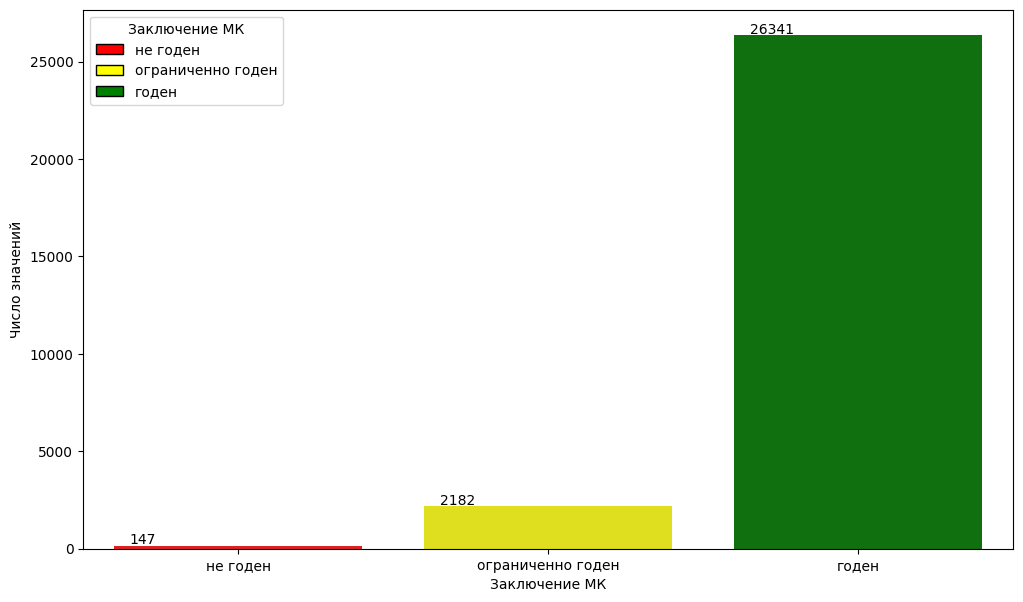

In [19]:
# Графически представляем данные до балансировки
drawConclusion012()

**Датафрейм сильно разбаланситрован.**

Удаляю 'лишние' строки категории 'годен' с пустым значением описания диагноза.

In [20]:
# Признаком для удаления является 2 == кЗаключениеМК и '' == ДиагнозОписание.
col_inx = df1.columns.get_loc('кЗаключениеМК')
col_lst = df1.iloc[:, col_inx].tolist()
#~ ДиагнозОписание
col_inx = df1.columns.get_loc('ДиагнозОписание')
col_lst2 = df1.iloc[:, col_inx].tolist()
for i in range(len(col_lst)):
  if 2 == col_lst[i]:
    i_elem = col_lst2[i]
    if (i_elem == i_elem):
      if not i_elem:
        col_lst2[i] = 'DIAGNOSIS_NAN'

print(f'размеры датафрейма df1 до удаления: {df1.shape}')
df1 = df1.assign(ДиагнозОписание=col_lst2)
df1 = df1.drop(df1[(df1['ДиагнозОписание'] == 'DIAGNOSIS_NAN')].index)
print(f'размеры датафрейма df1 после удаления: {df1.shape}')

размеры датафрейма df1 до удаления: (28670, 26)
размеры датафрейма df1 после удаления: (14691, 26)


0: не годен: 147
1: ограниченно годен: 2182
2: годен: 12362
--------------------------------------------------
общее число значений: 14691


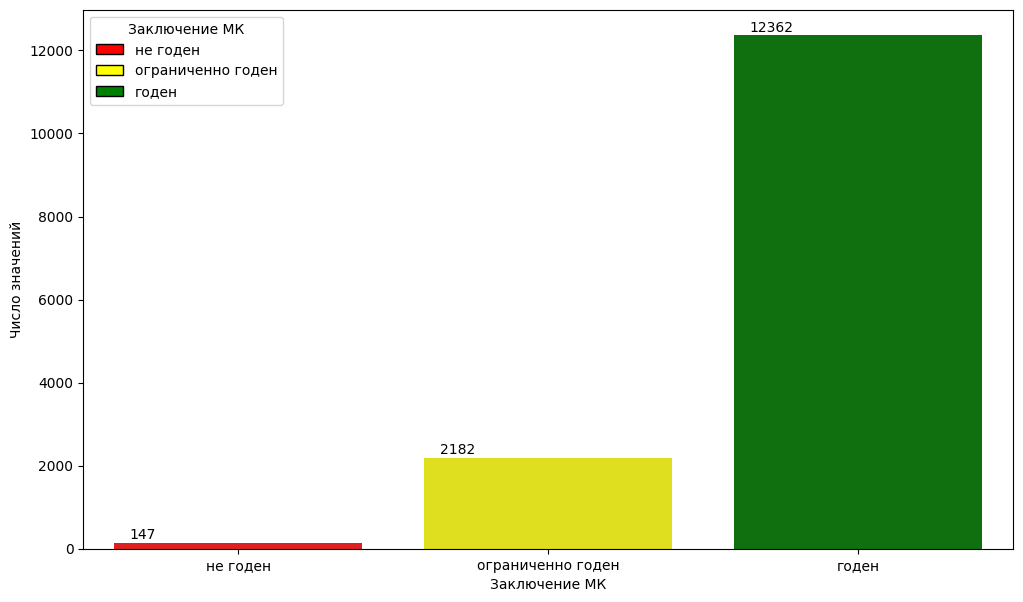

In [21]:
drawConclusion012()

Пронализировал колонки с пустыми значениями:

In [22]:
# # КлиентДатаРождения
# # КлиентПол
# # ДатаЗавершенияМедосмотра
# # ТипМедосмотра
# # ПсихОсвидетельствование
#  # Цех
# # Профессия
#  # ВредныеФакторы
# # ДиагнозМКБ
# nan_lst = df1[df1['ДиагнозМКБ'].isnull()].index
# u_lst = df1['ДиагнозМКБ'].unique().tolist()
# print('ДиагнозМКБ: ')
# print(f'  число строк с пустыми значениями: {len(nan_lst)}')
# print(f'  уникальные значения: {len(u_lst)}: {u_lst}')

Аналогично пустным данным по описанию диагноза рассматриваю 'ВредныеФакторы' для удаления записей с заключением 'годен':

In [23]:
col_inx = df1.columns.get_loc('кЗаключениеМК')
col_lst = df1.iloc[:, col_inx].tolist()
#~ ВредныеФакторы - Harmful Factors
col_inx = df1.columns.get_loc('ВредныеФакторы')
col_lst2 = df1.iloc[:, col_inx].tolist()
hf_count2 = 0
for i in range(len(col_lst)):
  if 2 == col_lst[i]:
    i_elem = col_lst2[i]
    if (i_elem == i_elem):
      if not i_elem:
        hf_count2 += 1

print(f'число строк с пустыми значениями в колонке "ВредныеФакторы" для записей "годен": {hf_count2}')

del col_inx
del col_lst
del col_lst2

число строк с пустыми значениями в колонке "ВредныеФакторы" для записей "годен": 0


Пустых данных в колонке 'ВредныеФакторы' с заключением 'годен' нет, поэтому строки не удаляю.

In [24]:
# Перенумерация строк
df1.reset_index(drop=True, inplace=True)
print(f'размеры датафрейма df1: {df1.shape}')
print('='*50)
df1.tail(3)

размеры датафрейма df1: (14691, 26)


,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ДиагнозМКБ,ДиагнозОписание,кЗаключениеМК,ккЗаключениеМК,кВозраст,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккЦехПрофессия
14688,3e83ea5c-66ee-11ed-8109-0cc47aab8067,f8a189c9-5937-11ea-80db-0cc47aab8067,1988-12-05T00:00:00,Мужской,Мужской,2022-11-18T00:00:00,Периодический,Периодический,False,b2178713-9949-11ec-80fe-0cc47aab8067,...,"Z00.0,H52.1",,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14689,8d9c6d97-c1f1-11ec-8100-0cc47aab8067,45677d5c-78d3-11eb-80e8-0cc47aab8067,1958-10-26T00:00:00,Женский,Женский,2022-04-22T00:00:00,Периодический,Периодический,True,0dac93bb-42ca-11e8-80ca-0cc47aab8067,...,"Z00.0,H52.0",,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14690,8ad457c8-60a5-11ed-8109-0cc47aab8067,c821860e-5e5e-11ed-8109-0cc47aab8067,1985-12-09T00:00:00,Мужской,Мужской,2022-11-10T00:00:00,Периодический,Периодический,False,00bbe942-2944-11ea-80d7-0cc47aab8067,...,"Z00.0,H52.1,I11.9",,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Искусственно добавляем минорные классы: 0 - не годен, 1 - ограниченно годен.**

In [25]:
# Искусственно добавляем классы: 0 - не годен, 1 - ограниченно годен
col_inx = df1.columns.get_loc('кЗаключениеМК')
col_lst = df1.iloc[:, col_inx].tolist()
# print(f'кЗаключениеМК: {len(col_lst)}: {col_lst}')

# 0 - не годен, 1 - ограниченно годен, 2 - годен
lst0 = list()
lst1 = list()
lst2 = list()
for i in range(df1.shape[0]):
  if 0 == col_lst[i]:
    lst0.append(i)
  elif 1 == col_lst[i]:
    lst1.append(i)
  elif 2 == col_lst[i]:
    lst2.append(i)

print(f'0 - не годен: {len(lst0)}')
print(f'1 - ограниченно годен: {len(lst1)}')
print(f'2 - годен: {len(lst2)}')
print(f'0+1+2: {len(lst0)+len(lst1)+len(lst2)}')

0 - не годен: 147
1 - ограниченно годен: 2182
2 - годен: 12362
0+1+2: 14691


In [26]:
# создаем копию нужных строк и добавляем их в отдельный df
adf0 = df1.loc[lst0].copy()
adf1 = df1.loc[lst1].copy()
print(f'размеры датафрейма adf0: {adf0.shape}, len(lst0): {len(lst0)}')
print(f'размеры датафрейма adf1: {adf1.shape}, len(lst1): {len(lst1)}')
print(f'размеры датафрейма df1: {df1.shape}')

# добавляем новый adf0, adf1 в исходный df1
#~~~
# for j in range(80):
#   df1 = pd.concat([df1, adf0], ignore_index=True)
# for j in range(4):
#   df1 = pd.concat([df1, adf1], ignore_index=True)
#~~~
for j in range(20):
  df1 = pd.concat([df1, adf0], ignore_index=True)
for j in range(1):
  df1 = pd.concat([df1, adf1], ignore_index=True)
#~~~

print('='*50)
print(f'размеры датафрейма df1: {df1.shape}')

размеры датафрейма adf0: (147, 26), len(lst0): 147
размеры датафрейма adf1: (2182, 26), len(lst1): 2182
размеры датафрейма df1: (14691, 26)
размеры датафрейма df1: (19813, 26)


0: не годен: 3087
1: ограниченно годен: 4364
2: годен: 12362
--------------------------------------------------
общее число значений: 19813


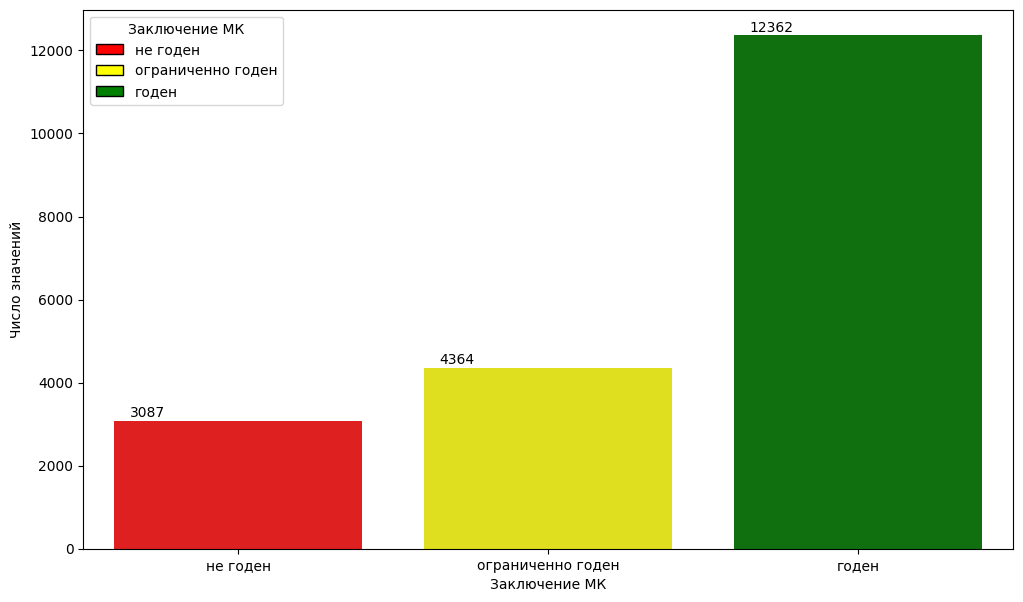

In [27]:
drawConclusion012()

Датасет стал более сбалансированным. Перемешиваем все строки после добавления.

In [28]:
print(f'размеры датафрейма df1: {df1.shape}')
df1.tail(3)

размеры датафрейма df1: (19813, 26)


,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ДиагнозМКБ,ДиагнозОписание,кЗаключениеМК,ккЗаключениеМК,кВозраст,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккЦехПрофессия
19810,3e83ea5c-66ee-11ed-8109-0cc47aab8067,f8a189c9-5937-11ea-80db-0cc47aab8067,1988-12-05T00:00:00,Мужской,Мужской,2022-11-18T00:00:00,Периодический,Периодический,False,b2178713-9949-11ec-80fe-0cc47aab8067,...,"Z00.0,H52.1",,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19811,8d9c6d97-c1f1-11ec-8100-0cc47aab8067,45677d5c-78d3-11eb-80e8-0cc47aab8067,1958-10-26T00:00:00,Женский,Женский,2022-04-22T00:00:00,Периодический,Периодический,True,0dac93bb-42ca-11e8-80ca-0cc47aab8067,...,"Z00.0,H52.0",,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19812,8ad457c8-60a5-11ed-8109-0cc47aab8067,c821860e-5e5e-11ed-8109-0cc47aab8067,1985-12-09T00:00:00,Мужской,Мужской,2022-11-10T00:00:00,Периодический,Периодический,False,00bbe942-2944-11ea-80d7-0cc47aab8067,...,"Z00.0,H52.1,I11.9",,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
#~Перемешиваем строки в нашей таблице
for i in range(5):
  df1 = df1.sample(frac=1).reset_index(drop=True)
  print(f'перемешивание: {i}')

print('='*50)
print(f'размеры датафрейма df1: {df1.shape}')
df1.tail(3)

перемешивание: 0
перемешивание: 1
перемешивание: 2
перемешивание: 3
перемешивание: 4
размеры датафрейма df1: (19813, 26)


,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ДиагнозМКБ,ДиагнозОписание,кЗаключениеМК,ккЗаключениеМК,кВозраст,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккЦехПрофессия
19810,2a98b3da-d598-11ec-8100-0cc47aab8067,be316423-b986-11ec-8100-0cc47aab8067,1965-11-17T00:00:00,Мужской,Мужской,2022-05-17T00:00:00,Периодический,Периодический,False,130c6cd1-b95b-11ec-8100-0cc47aab8067,...,Z00.0,[Z00.0] Общий медицинский осмотр,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19811,778260f6-8e3b-11ec-80fe-0cc47aab8067,7db15dca-5c54-11ea-80db-0cc47aab8067,1968-07-26T00:00:00,Мужской,Мужской,2022-02-15T00:00:00,Периодический,Периодический,False,91a46bc4-b7b0-11eb-80f3-0cc47aab8067,...,"H52.2,Z00.0,F07.0",[H52.2] Астигматизм|[Z00.0] Общий медицинский ...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19812,9ff6a2f1-b48d-11ec-8100-0cc47aab8067,83c1c628-3992-11e8-80c9-0cc47aab8067,1962-08-31T00:00:00,Мужской,Мужской,2022-04-05T00:00:00,Периодический,Периодический,False,5cdc2f61-3992-11e8-80c9-0cc47aab8067,...,"Z00.0,H52.0",[Z00.0] Общий медицинский осмотр|[H52.0] Гипер...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Добавление к датасету категориальных колонок

## ЗаключениеМК

In [30]:
print('ЗаключениеМК')
nan_lst = df1[df1['ЗаключениеМК'].isnull()].index
print(f'  число строк с пустыми значениями: {len(nan_lst)}')

ЗаключениеМК
  число строк с пустыми значениями: 0


In [31]:
col_inx = df1.columns.get_loc('кЗаключениеМК')
col_lst = df1.iloc[:, col_inx].tolist()
# print(f'кЗаключениеМК: {len(col_lst)}: {col_lst}')
# print(f'df1 число строк: {df1.shape[0]}')
# print(f'df1 число колонок: {df1.shape[1]}')

i_arr = np.zeros(df1.shape[0], dtype=int)
for i in range(df1.shape[0]):
  i_arr[i] = col_lst[i]

# Преобразование массива в формат one_hot_encoding (3-класса)
i_arr2 = utils.to_categorical(i_arr, 3)
ohe_lst2 = i_arr2.astype(int).tolist()
df1 = df1.assign(ккЗаключениеМК=ohe_lst2)
del i_arr2
del ohe_lst2

print(f'размеры датафрейма df1: {df1.shape}')
print('='*50)
df1.tail(3)

размеры датафрейма df1: (19813, 26)


,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ДиагнозМКБ,ДиагнозОписание,кЗаключениеМК,ккЗаключениеМК,кВозраст,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккЦехПрофессия
19810,2a98b3da-d598-11ec-8100-0cc47aab8067,be316423-b986-11ec-8100-0cc47aab8067,1965-11-17T00:00:00,Мужской,Мужской,2022-05-17T00:00:00,Периодический,Периодический,False,130c6cd1-b95b-11ec-8100-0cc47aab8067,...,Z00.0,[Z00.0] Общий медицинский осмотр,2,"[0, 0, 1]",NaN,NaN,NaN,NaN,NaN,NaN
19811,778260f6-8e3b-11ec-80fe-0cc47aab8067,7db15dca-5c54-11ea-80db-0cc47aab8067,1968-07-26T00:00:00,Мужской,Мужской,2022-02-15T00:00:00,Периодический,Периодический,False,91a46bc4-b7b0-11eb-80f3-0cc47aab8067,...,"H52.2,Z00.0,F07.0",[H52.2] Астигматизм|[Z00.0] Общий медицинский ...,1,"[0, 1, 0]",NaN,NaN,NaN,NaN,NaN,NaN
19812,9ff6a2f1-b48d-11ec-8100-0cc47aab8067,83c1c628-3992-11e8-80c9-0cc47aab8067,1962-08-31T00:00:00,Мужской,Мужской,2022-04-05T00:00:00,Периодический,Периодический,False,5cdc2f61-3992-11e8-80c9-0cc47aab8067,...,"Z00.0,H52.0",[Z00.0] Общий медицинский осмотр|[H52.0] Гипер...,2,"[0, 0, 1]",NaN,NaN,NaN,NaN,NaN,NaN


## Возраст

In [32]:
print('Возраст')
print('  КлиентДатаРождения')
nan_lst = df1[df1['КлиентДатаРождения'].isnull()].index
print(f'    число строк с пустыми значениями: {len(nan_lst)}')
print('  ДатаЗавершенияМедосмотра')
nan_lst = df1[df1['ДатаЗавершенияМедосмотра'].isnull()].index
print(f'    число строк с пустыми значениями: {len(nan_lst)}')

Возраст
  КлиентДатаРождения
    число строк с пустыми значениями: 0
  ДатаЗавершенияМедосмотра
    число строк с пустыми значениями: 0


In [33]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Получение категориального кода Возраст клиента
#~~~~~~~~~~~~~~~~~~~~~~~~
# Возраст клиента = ДатаЗавершенияМедосмотра - КлиентДатаРождения
#~~~~~~~~~~~~~~~~~~~~~~~~
def getAgeCategory(ageN, ageClassCount):
  '''
    Возраст превращаем в категориальный: до 18лет, далее через 5, всего 11 классов
    вход:
        ageN: возраст в годах
        ageClassCount: число классов
    выход:
        retVal: индекс категории: 0-17: 0, 18-22: 1, 23-27: 2, ...., 73..: 10
  '''
  #age2 = int((arg-13)/5)
  age2 = (ageN-13)/5
  retVal = max(0, min((ageClassCount-1),age2))
  return retVal

In [34]:
# КлиентДатаРождения
col_inx = df1.columns.get_loc('КлиентДатаРождения')
col_lst = df1.iloc[:, col_inx].tolist()
datetime_lst1 = []
for time_stamp in col_lst:
  datetime_obj = datetime.strptime(time_stamp, '%Y-%m-%dT%H:%M:%S')
  datetime_lst1.append(datetime_obj)

# ДатаЗавершенияМедосмотра
col_inx = df1.columns.get_loc('ДатаЗавершенияМедосмотра')
col_lst = df1.iloc[:, col_inx].tolist()
datetime_lst2 = []
for time_stamp in col_lst:
  datetime_obj = datetime.strptime(time_stamp, '%Y-%m-%dT%H:%M:%S')
  datetime_lst2.append(datetime_obj)

# рассчитываю возраст клиента
i_arr1 = np.zeros(df1.shape[0], dtype=int)
for i in range(df1.shape[0]):
  delta_dates21 = datetime_lst2[i].date() - datetime_lst1[i].date()
  delta_days21 = delta_dates21.days
  delta_years21 = delta_days21 // 365
  i_arr[i] = delta_years21
  i_arr1[i] = getAgeCategory(delta_years21, 11)

# Заполняем колонку 'кВозраст' значениями из массива i_arr
df1 = df1.assign(кВозраст=i_arr)

# Преобразование массива в формат one_hot_encoding (11-классов)
i_arr2 = utils.to_categorical(i_arr1, 11)
ohe_lst2 = i_arr2.astype(int).tolist()
df1 = df1.assign(ккВозраст=ohe_lst2)

del i_arr1
del i_arr2
del ohe_lst2
del datetime_lst1
del datetime_lst2

print(f'размеры датафрейма df1: {df1.shape}')
print('='*50)
df1.tail(3)

размеры датафрейма df1: (19813, 26)


,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ДиагнозМКБ,ДиагнозОписание,кЗаключениеМК,ккЗаключениеМК,кВозраст,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккЦехПрофессия
19810,2a98b3da-d598-11ec-8100-0cc47aab8067,be316423-b986-11ec-8100-0cc47aab8067,1965-11-17T00:00:00,Мужской,Мужской,2022-05-17T00:00:00,Периодический,Периодический,False,130c6cd1-b95b-11ec-8100-0cc47aab8067,...,Z00.0,[Z00.0] Общий медицинский осмотр,2,"[0, 0, 1]",56,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",NaN,NaN,NaN,NaN
19811,778260f6-8e3b-11ec-80fe-0cc47aab8067,7db15dca-5c54-11ea-80db-0cc47aab8067,1968-07-26T00:00:00,Мужской,Мужской,2022-02-15T00:00:00,Периодический,Периодический,False,91a46bc4-b7b0-11eb-80f3-0cc47aab8067,...,"H52.2,Z00.0,F07.0",[H52.2] Астигматизм|[Z00.0] Общий медицинский ...,1,"[0, 1, 0]",53,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",NaN,NaN,NaN,NaN
19812,9ff6a2f1-b48d-11ec-8100-0cc47aab8067,83c1c628-3992-11e8-80c9-0cc47aab8067,1962-08-31T00:00:00,Мужской,Мужской,2022-04-05T00:00:00,Периодический,Периодический,False,5cdc2f61-3992-11e8-80c9-0cc47aab8067,...,"Z00.0,H52.0",[Z00.0] Общий медицинский осмотр|[H52.0] Гипер...,2,"[0, 0, 1]",59,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",NaN,NaN,NaN,NaN


## КлиентПол

In [35]:
print('КлиентПол')
nan_lst = df1[df1['КлиентПол'].isnull()].index
print(f'  число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['КлиентПол'].unique().tolist()
print(f'  уникальные значения: {len(u_lst)}: {u_lst}')

КлиентПол
  число строк с пустыми значениями: 0
  уникальные значения: 2: ['Женский', 'Мужской']


In [36]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Получение категориального кода 'КлиентПол'
#~~~~~~~~~~~~~~~~~~~~~~~~
def getGenderCategory(arg):
  '''
    Бинарный пол клиента
    вход:
        arg: ['Женский', 'Мужской']
    выход:
        retVal: 0 - Женский, 1 - Мужской
  '''
  if 'Женский' == arg:
    retVal = 0
  else:
    retVal = 1
  return retVal

In [37]:
col_inx = df1.columns.get_loc('КлиентПол')
col_lst = df1.iloc[:, col_inx].tolist()

for i in range(df1.shape[0]):
  i_arr[i] = getGenderCategory(col_lst[i])

df1 = df1.assign(кКлиентПол=i_arr)

print(f'размеры датафрейма df1: {df1.shape}')
print('='*50)
df1.tail(3)

размеры датафрейма df1: (19813, 26)


,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ДиагнозМКБ,ДиагнозОписание,кЗаключениеМК,ккЗаключениеМК,кВозраст,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккЦехПрофессия
19810,2a98b3da-d598-11ec-8100-0cc47aab8067,be316423-b986-11ec-8100-0cc47aab8067,1965-11-17T00:00:00,Мужской,Мужской,2022-05-17T00:00:00,Периодический,Периодический,False,130c6cd1-b95b-11ec-8100-0cc47aab8067,...,Z00.0,[Z00.0] Общий медицинский осмотр,2,"[0, 0, 1]",56,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1,NaN,NaN,NaN
19811,778260f6-8e3b-11ec-80fe-0cc47aab8067,7db15dca-5c54-11ea-80db-0cc47aab8067,1968-07-26T00:00:00,Мужской,Мужской,2022-02-15T00:00:00,Периодический,Периодический,False,91a46bc4-b7b0-11eb-80f3-0cc47aab8067,...,"H52.2,Z00.0,F07.0",[H52.2] Астигматизм|[Z00.0] Общий медицинский ...,1,"[0, 1, 0]",53,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1,NaN,NaN,NaN
19812,9ff6a2f1-b48d-11ec-8100-0cc47aab8067,83c1c628-3992-11e8-80c9-0cc47aab8067,1962-08-31T00:00:00,Мужской,Мужской,2022-04-05T00:00:00,Периодический,Периодический,False,5cdc2f61-3992-11e8-80c9-0cc47aab8067,...,"Z00.0,H52.0",[Z00.0] Общий медицинский осмотр|[H52.0] Гипер...,2,"[0, 0, 1]",59,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",1,NaN,NaN,NaN


## ПсихОсвидетельствование

In [38]:
print('ПсихОсвидетельствование')
nan_lst = df1[df1['ПсихОсвидетельствование'].isnull()].index
print(f'  число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['ПсихОсвидетельствование'].unique().tolist()
print(f'  уникальные значения: {len(u_lst)}: {u_lst}')

ПсихОсвидетельствование
  число строк с пустыми значениями: 0
  уникальные значения: 2: [False, True]


In [39]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Получение категориального кода 'ПсихОсвидетельствование'
#~~~~~~~~~~~~~~~~~~~~~~~~
def getPsychicExaminationCategory(arg):
  '''
    Бинарный Тип ПсихОсвидетельствование
    вход:
        arg: [False, True]
    выход:
        retVal: 0 - False, 1 - True
  '''
  if False == arg:
    retVal = 0
  else:
    retVal = 1
  return retVal

In [40]:
col_inx = df1.columns.get_loc('ПсихОсвидетельствование')
col_lst = df1.iloc[:, col_inx].tolist()

for i in range(df1.shape[0]):
  i_arr[i] = getPsychicExaminationCategory(col_lst[i])

df1 = df1.assign(кПсихОсвидетельствование=i_arr)

print(f'размеры датафрейма df1: {df1.shape}')
print('='*50)
df1.tail(3)

размеры датафрейма df1: (19813, 26)


,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ДиагнозМКБ,ДиагнозОписание,кЗаключениеМК,ккЗаключениеМК,кВозраст,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккЦехПрофессия
19810,2a98b3da-d598-11ec-8100-0cc47aab8067,be316423-b986-11ec-8100-0cc47aab8067,1965-11-17T00:00:00,Мужской,Мужской,2022-05-17T00:00:00,Периодический,Периодический,False,130c6cd1-b95b-11ec-8100-0cc47aab8067,...,Z00.0,[Z00.0] Общий медицинский осмотр,2,"[0, 0, 1]",56,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1,0,NaN,NaN
19811,778260f6-8e3b-11ec-80fe-0cc47aab8067,7db15dca-5c54-11ea-80db-0cc47aab8067,1968-07-26T00:00:00,Мужской,Мужской,2022-02-15T00:00:00,Периодический,Периодический,False,91a46bc4-b7b0-11eb-80f3-0cc47aab8067,...,"H52.2,Z00.0,F07.0",[H52.2] Астигматизм|[Z00.0] Общий медицинский ...,1,"[0, 1, 0]",53,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1,0,NaN,NaN
19812,9ff6a2f1-b48d-11ec-8100-0cc47aab8067,83c1c628-3992-11e8-80c9-0cc47aab8067,1962-08-31T00:00:00,Мужской,Мужской,2022-04-05T00:00:00,Периодический,Периодический,False,5cdc2f61-3992-11e8-80c9-0cc47aab8067,...,"Z00.0,H52.0",[Z00.0] Общий медицинский осмотр|[H52.0] Гипер...,2,"[0, 0, 1]",59,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",1,0,NaN,NaN


## ВредныеФакторы

In [41]:
print('ВредныеФакторы')
nan_lst = df1[df1['ВредныеФакторы'].isnull()].index
print(f'  число строк с пустыми значениями: {len(nan_lst)}')

ВредныеФакторы
  число строк с пустыми значениями: 59


In [42]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Расщепление строки по запятым
#~~~~~~~~~~~~~~~~~~~~~~~~
def comma_string_split(arg):
  '''
    Расщепление строки по запятым, удаление пробелов перед словом и после
    вход:
        arg: строка с запятыми или без запятых
    выход:
        retVal: список строк, разделенных запятыми,
        если строк пустая или nan, то вернется пустой список,
        если строка не содержит запятые, то вернется список, состоящий из одного элемента
  '''
  # результирующий список
  retVal = list()
  # проверяем на nan
  if (arg == arg):
    # проверяем, что строка не пустая
    if arg:
      # приводим к нижнему регистру, удаляем пробелы в начале и конце слова
      #str1 = arg.lower().strip()
      str1 = arg.strip()
      # разбиваем строку по запятым и возвращаем список
      str_lst1 = str1.split(',')
      for str_item1 in str_lst1:
        str_item2 = str_item1.strip()
        # проверяем, что строка не пустая
        if str_item2:
          retVal.append(str_item2)

  return retVal

In [43]:
# Формируем столбец-список значений вредных факторов, заменяем nan - пустыми строками,
# убираем пробелы перед и после значений
col_inx = df1.columns.get_loc('ВредныеФакторы')
col_lst = df1.iloc[:, col_inx].tolist()

# Harmful Factors
hf_lst = [''] * df1.shape[0]

for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      #расщепляем по запятым
      elem_lst = comma_string_split(i_elem)
      hf_lst[i] = ",".join(elem_lst)

print(f'hf_lst: {len(hf_lst)}: {hf_lst}')

hf_lst: 19813: ['04.02.2005', '18.1,23', '23', '23', '25', '23,4.2.5', '23', '4.7,4.8,5.1', '4.3.1,4.3.2,4.4,6.1,8', '4.3.2,4.4,5.1,6.2,11.1,11.4,18.1', '25,25', '18.2,18.1,11.1,11.4,4.4', '5.2,23,5.2,23', '4.1,6.2,18.1,18.2,4.1,6.2,18.1,18.2', '4.3.1,4.3.2,4.4,5.1,6.1,11.1,13,15', '23', '4.4,5.1,6.1,11.1,15', '4.4,5.1,6.2,11.1,11.4', '1.14.2,1.29.2,1.29.4,1.30.1,1.34.1,1.36.1,1.37.1,1.50', '25', '6.2,17,18.2', '25', '1.50,4.3.1,4.3.2,11.1,18', '6,17', '4.2.5,25', '23', '4.7,4.8,5.1,6,17', '1.50,4.4,5.1', '4.4,5.1', '15', '4.2.5,5.2.1,6.2,9,4.2.5,5.2.1,6.2,9', '4.2.5,15', '4.2.5,27', '6.2,11.1', '1.50,4.3.2,4.4,18.1,18.2', '23', '4.2.5', '4.2.5', '1.50,4.7,5.1,6.1,11.1,13', '2.4.2,2.4.3,27', '1.15,4.4,4.7,6.2,12,17,18.2', '1.1,1.8.1.1,1.8.1.2,1.14.2,1.18.3,1.19.1,1.29.1,1.29.2,1.30.1,1.34.1,1.36.1,1.37.1,1.50', '4.2.5,6.1,11.3,18.1', '4.2.5,15', '5.1,11.4,6.2', '27', '1.3,1.14.2,5.1', '25', '9', '3.1.1,4.3.1,4.4,5.1,6,15,17', '1.1,1.17,1.23,1.39,4.2.1,4.4,5.1,6.1,11.4', '4.4,18.1,4.4,1

In [44]:
# Формируем список уникальных значений вредных факторов
# Harmful Factors
u_hf_lst = list()

for i in range(len(hf_lst)):
  i_elem = hf_lst[i]
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      #расщепляем по запятым
      elem_lst = comma_string_split(i_elem)
      if len(elem_lst) > 0:
        for elem1_lst in elem_lst:
          if len(u_hf_lst) > 0:
            # проверяем, что этого элемента нет в списке
            if not (elem1_lst in u_hf_lst):
              u_hf_lst.append(elem1_lst)
          else:
            u_hf_lst.append(elem1_lst)

print(f'{len(u_hf_lst)}: u_hf_lst: {u_hf_lst}')

162: u_hf_lst: ['04.02.2005', '18.1', '23', '25', '4.2.5', '4.7', '4.8', '5.1', '4.3.1', '4.3.2', '4.4', '6.1', '8', '6.2', '11.1', '11.4', '18.2', '5.2', '4.1', '13', '15', '1.14.2', '1.29.2', '1.29.4', '1.30.1', '1.34.1', '1.36.1', '1.37.1', '1.50', '17', '18', '6', '5.2.1', '9', '27', '2.4.2', '2.4.3', '1.15', '12', '1.1', '1.8.1.1', '1.8.1.2', '1.18.3', '1.19.1', '1.29.1', '11.3', '1.3', '3.1.1', '1.17', '1.23', '1.39', '4.2.1', '1.52', '4.9', '22', '14', '4.5', '11', '3.1.2', '3.1.7', '24', '06.фев', '10', '4.2.4', '4.10', '1.36', '1.14', '18.янв', '26', '4.3', '4.6', '1.49', '1.5', '1.37.2', '3.1', '1.8.1', '3.2', '4.2.2', '05.янв', '1.8.2.1', '1.8.2.2', '1.8.3.1', '1.8.3.2', '1.48', '1.24', '1.37.1.2', '1.49.14', '3.1.9.3', '1.47.7', '4.2.3', '1.27.1', '11.янв', '3.1.8', '1.2', '1.44', '16', '1.45.1', '3.1.3', '11.2', '3.4', 'янв.48', '11.мар', '1.49.4', '1.5.1', '4.2', '3.1.8.3', '2.3', '2.4.1', '1.29.3', '1.14.1', '04.апр', '1.25', '1.4', '1.37', '3.3', '3.1.8.2', '18.фев', '2

In [45]:
# Оценим число повторений ВредныхФакторов,
# будем использовать в нейросети только наиболее частые,
# остальные, которые встречаются редко обозначим - "все остальные"
# Создаем словарь ВредныеФакторы: ключи - названия вредных факторов, значения - число повторений
u_hf_dict = {}
for i_elem in u_hf_lst:
  u_hf_dict[i_elem] = 0

# пробегаемся по всем строкам колонки и заполняем словарь
for i in range(len(hf_lst)):
  i_elem = hf_lst[i]
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      #расщепляем по запятым
      elem_lst = comma_string_split(i_elem)
      if len(elem_lst) > 0:
        for elem1_lst in elem_lst:
          u_hf_dict[elem1_lst] += 1

# print(f'{len(u_hf_dict)}: u_hf_lst: {u_hf_dict}')

# сортируем словарь по убыванию
u_hf_sort_dict = dict(sorted(u_hf_dict.items(), key=lambda x: x[1], reverse=True))

# print(f'{len(u_hf_sort_dict)}: u_hf_sort_dict: {u_hf_sort_dict}')

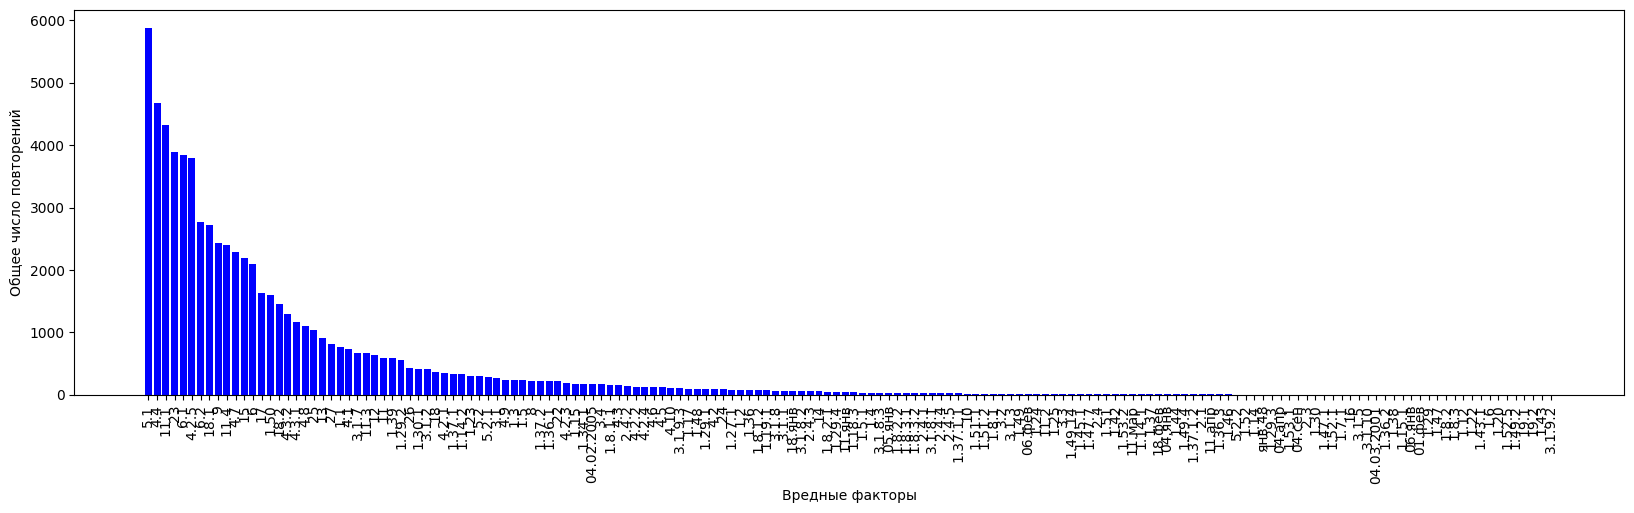

In [46]:
# Отобразим на столбчатую диаграмму - частоту использования наших признаков
plt.figure(figsize=(20, 5))
plt.bar(u_hf_sort_dict.keys(), u_hf_sort_dict.values(), color='blue')
plt.xticks(rotation=90)
plt.xlabel('Вредные факторы')
plt.ylabel('Общее число повторений')
plt.gca().set_facecolor('white')
plt.show()

**Из графика видно, что 'ошибочный' признак '04.02.2005' - 46-ой и основное влияние оказывают признаки до него, остальные - незначительное, поэтому оставим только первых 45 признаков.**

In [47]:
# Из графика видно, что 'ошибочный' признак '04.02.2005' - 46-ой
# и основное влияние оказывают признаки до него, остальные - незначительное,
# поэтому оставим только первых 45 признаков
u_hf_lst = list(u_hf_sort_dict.keys())[:45]

del u_hf_dict
del u_hf_sort_dict

print(f'{len(u_hf_lst)}: u_hf_lst: {u_hf_lst}')

45: u_hf_lst: ['5.1', '4.4', '11.1', '23', '6.1', '4.2.5', '6.2', '18.1', '9', '11.4', '4.7', '15', '6', '17', '1.50', '18.2', '4.3.2', '4.3.1', '4.8', '25', '13', '27', '1.1', '4.1', '3.1.7', '11.3', '12', '11', '1.39', '1.29.2', '26', '1.30.1', '3.1.2', '18', '4.2.1', '1.37.1', '1.14.2', '1.23', '5.2', '5.2.1', '3.1', '4.9', '1.3', '1.5', '8']


In [48]:
#~~~~~~~~~~~~~~~~~~~~~~~~
#multi_hot_encoding
hf_mhe_lst = list()

# число классов
harmful_factors_class_count = len(u_hf_lst) + 1
# то есть по умолчанию выбираем индекс вредного фактора, которого нет в списке
# наших выбранных и ограниченных уникальных вредных факторов - вредный фактор - `все остальные`
nan_inx = len(u_hf_lst)

# пробегаемся по всем строкам колонки
for i in range(len(hf_lst)):
  i_elem = hf_lst[i]
  # устанавливаем все признаки в нули
  i_mhe_lst = [0] * harmful_factors_class_count
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      #расщепляем по запятым
      elem_lst = comma_string_split(i_elem)
      if len(elem_lst) > 0:
        for elem1_lst in elem_lst:
          # проверяем, есть ли этот элемент в списке
          if elem1_lst in u_hf_lst:
            inx = u_hf_lst.index(elem1_lst)
            i_mhe_lst[inx] = 1
          else:
            i_mhe_lst[nan_inx] = 1
      else:
        i_mhe_lst[nan_inx] = 1
    else:
      i_mhe_lst[nan_inx] = 1
  else:
    i_mhe_lst[nan_inx] = 1
  #~~~
  hf_mhe_lst.append(i_mhe_lst)

df1 = df1.assign(ккВредныеФакторы=hf_mhe_lst)
del hf_lst
del u_hf_lst
del hf_mhe_lst

print(f'размеры датафрейма df1: {df1.shape}')
print('='*50)
df1.tail(3)

размеры датафрейма df1: (19813, 26)


,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ДиагнозМКБ,ДиагнозОписание,кЗаключениеМК,ккЗаключениеМК,кВозраст,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккЦехПрофессия
19810,2a98b3da-d598-11ec-8100-0cc47aab8067,be316423-b986-11ec-8100-0cc47aab8067,1965-11-17T00:00:00,Мужской,Мужской,2022-05-17T00:00:00,Периодический,Периодический,False,130c6cd1-b95b-11ec-8100-0cc47aab8067,...,Z00.0,[Z00.0] Общий медицинский осмотр,2,"[0, 0, 1]",56,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN
19811,778260f6-8e3b-11ec-80fe-0cc47aab8067,7db15dca-5c54-11ea-80db-0cc47aab8067,1968-07-26T00:00:00,Мужской,Мужской,2022-02-15T00:00:00,Периодический,Периодический,False,91a46bc4-b7b0-11eb-80f3-0cc47aab8067,...,"H52.2,Z00.0,F07.0",[H52.2] Астигматизм|[Z00.0] Общий медицинский ...,1,"[0, 1, 0]",53,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1,0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",NaN
19812,9ff6a2f1-b48d-11ec-8100-0cc47aab8067,83c1c628-3992-11e8-80c9-0cc47aab8067,1962-08-31T00:00:00,Мужской,Мужской,2022-04-05T00:00:00,Периодический,Периодический,False,5cdc2f61-3992-11e8-80c9-0cc47aab8067,...,"Z00.0,H52.0",[Z00.0] Общий медицинский осмотр|[H52.0] Гипер...,2,"[0, 0, 1]",59,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",1,0,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",NaN


## Текстовые признаки (Цех+Профессия: Tokenizer-Bag of Words)

**Cчитаю, что цех и профессию необходимо объединить в один признак.**

In [49]:
print(f'размеры датафрейма: df1: {df1.shape}')

print('Цех')
nan_lst = df1[df1['Цех'].isnull()].index
print(f'  число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['Цех'].unique().tolist()
print(f'  уникальные значения: {len(u_lst)}')

print('Профессия')
nan_lst = df1[df1['Профессия'].isnull()].index
print(f'  число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['Профессия'].unique().tolist()
print(f'  уникальные значения: {len(u_lst)}')

размеры датафрейма: df1: (19813, 26)
Цех
  число строк с пустыми значениями: 10962
  уникальные значения: 585
Профессия
  число строк с пустыми значениями: 0
  уникальные значения: 2840


In [50]:
# branch + profession
# результирующий список
brh_prn_lst = [""] * df1.shape[0]
# print(f'df1 число строк: {df1.shape[0]}, len(brh_prn_lst): {len(brh_prn_lst)}, {brh_prn_lst}')

#~~~~~~~~~~~~~~~~~~~~~~~~
#~~~Цех
col_inx = df1.columns.get_loc('Цех')
col_lst = df1.iloc[:, col_inx].tolist()
# print(f'df1 число строк: {df1.shape[0]}, len(col_lst): {len(col_lst)}, {col_lst}')

for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  # print(f'{i}->{df1.shape[0]}: i_elem: {i_elem}' )
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      i_elem2 = i_elem.lower().strip()
      # print(f'  i_elem2: {i_elem2}')
      brh_prn_lst[i] = i_elem2
    else:
      brh_prn_lst[i] = 'без отдела'
  else:
    brh_prn_lst[i] = 'без отдела'

# print(f'df1 число строк: {df1.shape[0]}, len(brh_prn_lst): {len(brh_prn_lst)}, {brh_prn_lst}')

#~~~~~~~~~~~~~~~~~~~~~~~~
#~~~Профессия
col_inx = df1.columns.get_loc('Профессия')
col_lst = df1.iloc[:, col_inx].tolist()
# print(f'df1 число строк: {df1.shape[0]}, len(col_lst): {len(col_lst)}, {col_lst}')

for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  # print(f'{i}->{df1.shape[0]}: i_elem: {i_elem}' )
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      i_elem2 = i_elem.lower().strip()
      # print(f'  i_elem2: {i_elem2}')
      brh_prn_lst[i] += ' ' + i_elem2

# print(f'df1 число строк: {df1.shape[0]}, len(brh_prn_lst): {len(brh_prn_lst)}, {brh_prn_lst}')
print(f'df1 число строк: {df1.shape[0]}, len(brh_prn_lst): {len(brh_prn_lst)}')
# пример цех+профессия 123-ей записи-строки
print(brh_prn_lst[123])

df1 число строк: 19813, len(brh_prn_lst): 19813
без отдела монтажник технологических трубопроводов


In [51]:
#################
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
#################

#определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
#~"Сеанс прекращен, так как объем ОЗУ полностью исчерпан".
#~Поэтому уменьшаю текущее число ограничивающее вредные факторы
# maxWordsCount = 10000
# maxWordsCount = 700
maxWordsCount = 3000
# число строк: 3014, len(brh_prn_items): 765, [('unknown', 1), ('отдела', 2), ('без', 3), ('разряда', 4), ('водитель', 5), ('автомобиля', 6), ('по', 7), ('слесарь', 8), ('6', 9)

#для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
#выше задаем параметры:
#(num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
#(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') - избавляемся от ненужных символов
#(lower=True) - приводим слова к нижнему регистру
#(split=' ') - разделяем слова по пробелу
#(char_level=False) - просим токенайзер не удалять однобуквенные слова

# "скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
tokenizer.fit_on_texts(brh_prn_lst)

#Вытаскиваем индексы слов для просмотра
brh_prn_items = list(tokenizer.word_index.items())
print(f'df1 число строк: {df1.shape[0]}, len(brh_prn_items): {len(brh_prn_items)}, {brh_prn_items}')

df1 число строк: 19813, len(brh_prn_items): 2301, [('unknown', 1), ('отдела', 2), ('без', 3), ('по', 4), ('инженер', 5), ('и', 6), ('водитель', 7), ('разряда', 8), ('отдел', 9), ('слесарь', 10), ('монтажник', 11), ('оператор', 12), ('технологических', 13), ('специалист', 14), ('участок', 15), ('машинист', 16), ('скважин', 17), ('ведущий', 18), ('категории', 19), ('ремонту', 20), ('ремонта', 21), ('повар', 22), ('цех', 23), ('уфа', 24), ('автомобиля', 25), ('5', 26), ('капитального', 27), ('трубопроводов', 28), ('6', 29), ('ооо', 30), ('служба', 31), ('начальник', 32), ('старший', 33), ('1', 34), ('главный', 35), ('продавец', 36), ('мастер', 37), ('установок', 38), ('2', 39), ('текущего', 40), ('менеджер', 41), ('группа', 42), ('работ', 43), ('4', 44), ('электромонтажник', 45), ('№2', 46), ('с', 47), ('на', 48), ('обслуживанию', 49), ('электромонтер', 50), ('025', 51), ('электрогазосварщик', 52), ('подразделение', 53), ('сервис', 54), ('помощник', 55), ('экспедитор', 56), ('в', 57), ('р

In [52]:
#преобразовываем текст в последовательность индексов согласно частотному словарю
#обучающие тесты в индексы
brh_prn_inxs = tokenizer.texts_to_sequences(brh_prn_lst)
print(f'df1 число строк: {df1.shape[0]}, len(brh_prn_inxs): {len(brh_prn_inxs)}, {brh_prn_inxs}')

df1 число строк: 19813, len(brh_prn_inxs): 19813, [[3, 2, 532], [3, 2, 7], [3, 2, 41], [3, 2, 36], [140, 306, 47, 307, 62, 657, 6, 1146], [3, 2, 12, 166, 57, 322, 1726, 131], [3, 2, 235], [3, 2, 10, 4, 20, 194, 29, 8], [3, 2, 16, 116, 335], [23, 40, 6, 27, 21, 17, 46, 16, 129], [3, 2, 33, 142], [3, 2, 12, 100, 144, 75, 29, 8], [3, 2, 281, 297], [160, 161, 162, 163, 164, 158, 7, 25], [3, 2, 55, 88, 512, 6, 513, 470, 17, 48, 402, 6, 403, 29, 8], [3, 2, 36, 65], [3, 2, 11, 13, 28], [23, 40, 6, 27, 21, 17, 46, 55, 88, 27, 21, 17], [3, 2, 18, 14], [3, 2, 62], [42, 4, 215, 216, 201, 153], [140, 145, 93, 249, 62, 641, 343], [3, 2, 7, 25, 1060], [30, 78, 83], [3, 2, 86], [3, 2, 56], [3, 2, 11, 4, 77, 81, 6, 84, 69], [3, 2, 12, 217, 26, 19, 4, 70, 24], [218, 31, 95], [737, 228, 642, 6, 679, 32, 323], [3, 2, 32, 103, 855], [9, 126, 244, 12, 133, 47, 182], [3, 2, 242, 308], [3, 2, 18, 5], [3, 2, 7, 25, 256], [51, 24, 58, 73, 80], [3, 2, 41], [3, 2, 12, 404, 389], [3, 2, 135], [3, 2, 174, 141, 437

In [53]:
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
# Подаем xTrain в виде списка чтобы метод успешно сработал
xTrainProf01 = tokenizer.sequences_to_matrix(brh_prn_inxs)
# Размер обучающей выборки, сформированной по Bag of Words
print(xTrainProf01.shape)
print(f'xTrainProf01 число строк : {xTrainProf01.shape[0]}')
print(f'xTrainProf01 число столбцов : {xTrainProf01.shape[1]}')
print(xTrainProf01[0][0:100])

(19813, 3000)
xTrainProf01 число строк : 19813
xTrainProf01 число столбцов : 3000
[0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [54]:
n = 123
# Цех+Профессия
print(brh_prn_lst[n])
# Профессия через индексы
print(brh_prn_inxs[n])

без отдела монтажник технологических трубопроводов
[3, 2, 11, 13, 28]


In [55]:
brh_mhe_lst = xTrainProf01.astype(int).tolist()
# print(f'df1 число строк: {df1.shape[0]}, len(brh_mhe_lst): {len(brh_mhe_lst)}, {brh_mhe_lst}')

df1 = df1.assign(ккЦехПрофессия=brh_mhe_lst)
del brh_prn_lst
del brh_mhe_lst
del brh_prn_inxs
del xTrainProf01


print(f'размеры датафрейма df1: {df1.shape}')
print('='*50)
df1.tail(3)

размеры датафрейма df1: (19813, 26)


,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ДиагнозМКБ,ДиагнозОписание,кЗаключениеМК,ккЗаключениеМК,кВозраст,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккЦехПрофессия
19810,2a98b3da-d598-11ec-8100-0cc47aab8067,be316423-b986-11ec-8100-0cc47aab8067,1965-11-17T00:00:00,Мужской,Мужской,2022-05-17T00:00:00,Периодический,Периодический,False,130c6cd1-b95b-11ec-8100-0cc47aab8067,...,Z00.0,[Z00.0] Общий медицинский осмотр,2,"[0, 0, 1]",56,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
19811,778260f6-8e3b-11ec-80fe-0cc47aab8067,7db15dca-5c54-11ea-80db-0cc47aab8067,1968-07-26T00:00:00,Мужской,Мужской,2022-02-15T00:00:00,Периодический,Периодический,False,91a46bc4-b7b0-11eb-80f3-0cc47aab8067,...,"H52.2,Z00.0,F07.0",[H52.2] Астигматизм|[Z00.0] Общий медицинский ...,1,"[0, 1, 0]",53,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1,0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
19812,9ff6a2f1-b48d-11ec-8100-0cc47aab8067,83c1c628-3992-11e8-80c9-0cc47aab8067,1962-08-31T00:00:00,Мужской,Мужской,2022-04-05T00:00:00,Периодический,Периодический,False,5cdc2f61-3992-11e8-80c9-0cc47aab8067,...,"Z00.0,H52.0",[Z00.0] Общий медицинский осмотр|[H52.0] Гипер...,2,"[0, 0, 1]",59,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",1,0,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Итоговый датафрейм, число пропусков

In [56]:
print(f'размеры датафрейма df1: {df1.shape}')
print(f'  число строк: {df1.shape[0]}')
print(f'  число колонок: {df1.shape[1]}')
print('='*50)
nan_cell_count = df1.isna().sum().sum()
nan_cell_count_proc = nan_cell_count*100/df1.size
print(f'общее количество пропусков во всей таблице (колонка цех): {nan_cell_count}, {round(nan_cell_count_proc, 2)}%')

размеры датафрейма df1: (19813, 26)
  число строк: 19813
  число колонок: 26
общее количество пропусков во всей таблице (колонка цех): 11527, 2.24%


# Обучение Нейросети

## Создаем выборки для обучения и проверки нейросети

In [57]:
# y_data - one-hot-encoding целевой массив результатов
df_y = df1['ккЗаключениеМК'].apply(pd.Series)
print(f'размеры датафрейма df_y: {df_y.shape}')
print('='*50)
df_y.tail(3)

размеры датафрейма df_y: (19813, 3)


,0,1,2
19810,0,0,1
19811,0,1,0
19812,0,0,1


In [58]:
# преобразуем в numpy массив типа float
# y_data = df_y.astype(float).to_numpy()
y_data = df_y.astype(np.float32).to_numpy()

print('y_data:')
print(f'  количество осей: {y_data.ndim}')
print(f'  форма массива: {y_data.shape}')
print(f'  количество значений: {y_data.size}')
del df_y

y_data:
  количество осей: 2
  форма массива: (19813, 3)
  количество значений: 59439


In [59]:
# x_data - массив категориальных колонок
df_x = df1.drop(['ДокументПрохождениеМедосмотра',
                 'Клиент',
                 'КлиентДатаРождения',
                 'КлиентПол',
                 'КлиентПолПредставление',
                 'ДатаЗавершенияМедосмотра',
                 'ТипМедосмотра',
                 'ТипМедосмотраПредставление',
                 'ПсихОсвидетельствование',
                 'Контрагент',
                 'Цех',
                 'Профессия',
                 'ЗаключениеМК',
                 'ЗаключениеМКПредставление',
                 'Заключение',
                 'ВредныеФакторы',
                 'ДиагнозМКБ',
                 'ДиагнозОписание',
                 'кЗаключениеМК',
                 'кВозраст'
                 ], axis = 1)

print(f'размеры датафрейма df_x: {df_x.shape}')
print('='*50)
df_x.tail(3)

размеры датафрейма df_x: (19813, 6)


,ккЗаключениеМК,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккЦехПрофессия
19810,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
19811,"[0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1,0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
19812,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",1,0,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [60]:
# трансформируем one-multi-hot-encoding списки в отдельные колонки
split_col_names = list()
#~~~~~~~~~~~~~~~~~~~~~~~~
split_col_names.append('ккЗаключениеМК')
split_col_names.append('ккВозраст')
split_col_names.append('ккВредныеФакторы')
split_col_names.append('ккЦехПрофессия')
#~~~~~~~~~~~~~~~~~~~~~~~~

for col_name in split_col_names:
  df_x = pd.concat([df_x.drop(col_name, axis=1), df_x[col_name].apply(pd.Series)], axis=1)

del split_col_names

print(f'размеры датафрейма df_x: {df_x.shape}')
print('='*50)
df_x.tail(3)

размеры датафрейма df_x: (19813, 3062)


,кКлиентПол,кПсихОсвидетельствование,0,1,2,0,1,2,3,4,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
19810,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19811,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19812,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
# преобразуем в numpy массив типа float
# x_data = df_x.astype(float).to_numpy()
x_data = df_x.astype(np.float32).to_numpy()

print('x_data:')
print(f'  количество осей: {x_data.ndim}')
print(f'  форма массива: {x_data.shape}')
print(f'  количество значений: {x_data.size}')

x_data_row, x_data_col = x_data.shape
print(f'  число строк: {x_data_row}')
print(f'  число колонок: {x_data_col}')

del df_x

x_data:
  количество осей: 2
  форма массива: (19813, 3062)
  количество значений: 60667406
  число строк: 19813
  число колонок: 3062


In [62]:
# Переменные-настройки-параметры-для-обучения-сети
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
EPOCHS = 10
VERBOSE = 1
# TEST_DATA_SIZE, VALID_DATA_SIZE in percent value: 0..1
TEST_DATA_SIZE = 0.20
VALID_DATA_SIZE = 0.20

#~~~~~~~~~~~~~~~~~~~~~~~~
print(f'LEARNING_RATE: {LEARNING_RATE}')
print(f'BATCH_SIZE: {BATCH_SIZE}')
print(f'EPOCHS: {EPOCHS}')
print(f'VERBOSE: {VERBOSE}')
print(f'TEST_DATA_SIZE: {TEST_DATA_SIZE}')
print(f'VALID_DATA_SIZE: {VALID_DATA_SIZE}')

LEARNING_RATE: 0.001
BATCH_SIZE: 128
EPOCHS: 10
VERBOSE: 1
TEST_DATA_SIZE: 0.2
VALID_DATA_SIZE: 0.2


Разделяю датасет на две части: первые 20% (TEST_DATA_SIZE) записей - тестовая выборка, оставшиеся 80% (1.0 - TEST_DATA_SIZE) - выборка для обучения, которую в свою очередь также разделяю на две части, выделяя 20% (VALID_DATA_SIZE) на корректировку обучения. Тестовая выборка не учавствует в обучении, она неоходима только для проверки результатов.

In [63]:
test_count = int(x_data_row*TEST_DATA_SIZE)
print(f'test_count: {test_count}')

test_count: 3962


In [64]:
x_test = x_data[:test_count]
y_test = y_data[:test_count]
print('x_test:')
print(f'  количество осей: {x_test.ndim}')
print(f'  форма массива: {x_test.shape}')
print(f'  количество значений: {x_test.size}')
print('y_test:')
print(f'  количество осей: {y_test.ndim}')
print(f'  форма массива: {y_test.shape}')
print(f'  количество значений: {y_test.size}')

x_test:
  количество осей: 2
  форма массива: (3962, 3062)
  количество значений: 12131644
y_test:
  количество осей: 2
  форма массива: (3962, 3)
  количество значений: 11886


In [65]:
x_train = x_data[test_count:]
y_train = y_data[test_count:]
print('x_train:')
print(f'  количество осей: {x_train.ndim}')
print(f'  форма массива: {x_train.shape}')
print(f'  количество значений: {x_train.size}')
print('y_train:')
print(f'  количество осей: {y_train.ndim}')
print(f'  форма массива: {y_train.shape}')
print(f'  количество значений: {y_train.size}')

del x_data
del y_data

x_train:
  количество осей: 2
  форма массива: (15851, 3062)
  количество значений: 48535762
y_train:
  количество осей: 2
  форма массива: (15851, 3)
  количество значений: 47553


## Обучение нейронной сети

In [66]:
# Графическое представление результатов работы нейросети
#~~~~~~~~~~~~~~~~~~~~~~~~
def printNNChart(history_n):
  '''
    Отображенние на графике результатов работы нейронной сети (Neural Network)
    вход:
        history_n: массив результатов работы нейросети
  '''
  # Создание полотна для рисунка
  plt.figure(figsize=(18,5))

  # Задание первой (левой) области для построения графиков
  plt.subplot(1, 2, 1)
  # Отрисовка графиков 'loss' и 'val_loss' из значений словаря history.history
  plt.plot(history_n.history['loss'],
           color='blue',
           label = 'Значение ошибки на обучающем наборе')
  plt.plot(history_n.history['val_loss'],
           color='red',
           label = 'Значение ошибки на проверочном наборе')
  # Задание подписей осей
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Значение ошибки')
  plt.legend()
  plt.grid(which = 'major', color = 'black', alpha = 0.3)
  plt.minorticks_on()
  plt.grid(which = 'minor', color = 'gray', linestyle = '--', alpha = 0.3)

  # Задание второй (правой) области для построения графиков
  plt.subplot(1, 2, 2)
  # Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря history.history
  plt.plot(history_n.history['accuracy'],
           color='blue',
           label = 'Доля верных ответов на обучающем наборе')
  plt.plot(history_n.history['val_accuracy'],
           color='red',
           label = 'Доля верных ответов на проверочном наборе')
  # Задание подписей осей
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()
  plt.grid(which = 'major', color = 'black', alpha = 0.3)
  plt.minorticks_on()
  plt.grid(which = 'minor', color = 'gray', linestyle = '--', alpha = 0.3)

  # Фиксация графиков и рисование всей картинки
  plt.show()

In [67]:
# Создание модели
model1 = Sequential()

# Добавление слоев
model1.add(Dense(60, input_dim=x_train.shape[1], activation='relu'))

model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(30))

model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(10))

model1.add(Dense(3, activation = 'softmax'))

In [68]:
# Компиляция
model1.compile(loss='categorical_crossentropy',
               optimizer=Adam(learning_rate=LEARNING_RATE),
               metrics=['accuracy'])

In [69]:
# Обучение нейронной сети
history1 = model1.fit(x_train,                             # Обучающая выборка параметров
                      y_train,                             # Обучающая выборка целевого результата
                      batch_size=BATCH_SIZE,               # Размер батча (пакета)
                      epochs=EPOCHS,                       # Количество эпох обучения
                      validation_split=VALID_DATA_SIZE,    # Доля валидационной-корректирующей выборки
                      verbose=VERBOSE)                     # Отображение хода обучения

Epoch 1/10
100/100 [==============================] - 3s 14ms/step - loss: 0.2351 - accuracy: 0.9204 - val_loss: 0.4851 - val_accuracy: 0.9968
Epoch 2/10
100/100 [==============================] - 1s 12ms/step - loss: 0.0086 - accuracy: 0.9997 - val_loss: 0.2345 - val_accuracy: 1.0000
Epoch 3/10
100/100 [==============================] - 1s 11ms/step - loss: 0.0038 - accuracy: 0.9996 - val_loss: 0.0759 - val_accuracy: 1.0000
Epoch 4/10
100/100 [==============================] - 1s 12ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0159 - val_accuracy: 1.0000
Epoch 5/10
100/100 [==============================] - 2s 15ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 6/10
100/100 [==============================] - 2s 16ms/step - loss: 8.7191e-04 - accuracy: 1.0000 - val_loss: 4.2165e-04 - val_accuracy: 1.0000
Epoch 7/10
100/100 [==============================] - 1s 12ms/step - loss: 9.1172e-04 - accuracy: 0.9999 - val_loss: 1.2688e-04 - val_

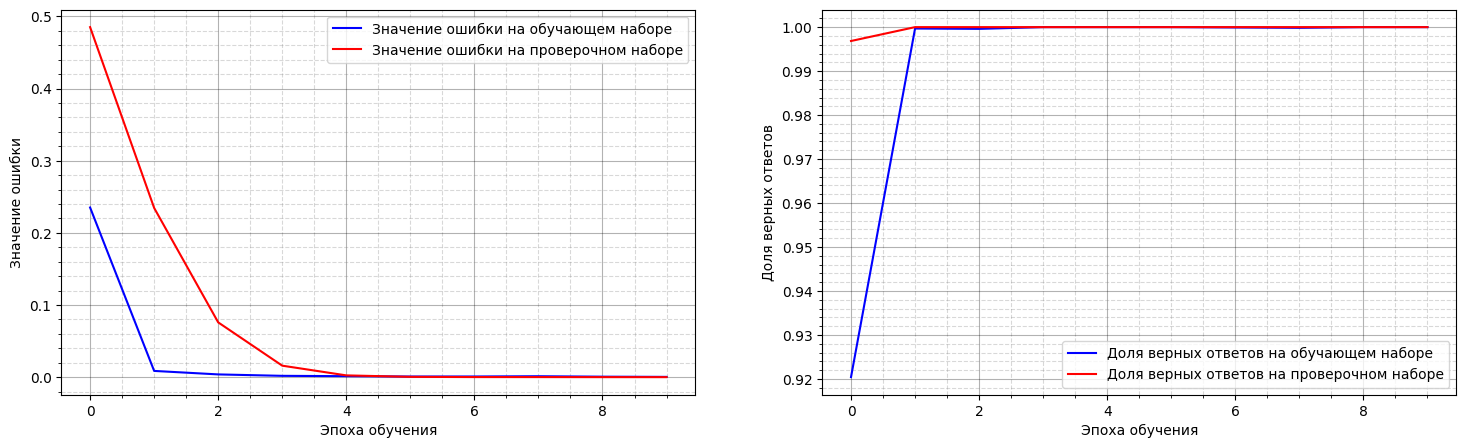

In [70]:
# Отобразим результаты на графике
printNNChart(history1)

## Оценка результатов

In [71]:
# Оценим результат работы нашей сети.
# Применим метод .evaluate() к нашей модели, в качестве параметров
# передадим ему тестовые выборки и согласие на отображение хода вычисления.

scores1 = model1.evaluate(x_test,
                          y_test,
                          verbose=1)

print('Процент верных ответов на тестовых данных:', round(scores1[1],2) * 100, '%')

124/124 [==============================] - 0s 3ms/step - loss: 2.8219e-05 - accuracy: 1.0000
Процент верных ответов на тестовых данных: 100.0 %


In [72]:
# Вывод значения точности распознавания на проверочной выборке по эпохам
print(f'Эпохи: {EPOCHS}')
print("="*50)

# val_accuracy
val_acc1 = history1.history['val_accuracy']
i_max = 0
val_acc_max = -1.0
for i in range(EPOCHS):
  # print(f'{i}->{EPOCHS}: {round(val_acc1[i], 3)}%')
  if val_acc1[i] > val_acc_max:
    val_acc_max = val_acc1[i]
    i_max = i

print(f'Самая точная нейронка под номером: {i_max} из {EPOCHS} эпох')
print(f'  достигла точности: {round(val_acc1[i]*100., 3)}%')

Эпохи: 10
Самая точная нейронка под номером: 1 из 10 эпох
  достигла точности: 100.0%


# Оценка предсказаний по тестовой выборке

In [73]:
# Распознавание ЗаключениеМК на тестовой выборке
# x_test, y_test -> массивы, которые не принимали участия в обучении нейронки
print('x_test, y_test -> массивы, которые не принимали участия в обучении нейронки:')
print('x_test:')
print(f'  количество осей: {x_test.ndim}')
print(f'  форма массива: {x_test.shape}')
print(f'  количество значений: {x_test.size}')
print('y_test:')
print(f'  количество осей: {y_test.ndim}')
print(f'  форма массива: {y_test.shape}')
print(f'  количество значений: {y_test.size}')

x_test, y_test -> массивы, которые не принимали участия в обучении нейронки:
x_test:
  количество осей: 2
  форма массива: (3962, 3062)
  количество значений: 12131644
y_test:
  количество осей: 2
  форма массива: (3962, 3)
  количество значений: 11886


In [74]:
pred1 = model1.predict(x_test)

# У нас три класса:
# 0 - не годен, 1 - ограниченно годен, 2 - годен
# Подсчитаем по каждому верное и неверное предсказания
arr_true = np.zeros(3, dtype=int)
arr_false = np.zeros(3, dtype=int)

for i in range(y_test.shape[0]):
  # Получение индекса самого большого элемента
  # потому что мы имеем дело с one-hot-encoding, поэтому необходимо
  # определить элемент в массиве с максимальным значением,
  # индекс этого элемента и будет говорить о верном элементе
  #~индекс тестового элемента
  y_inx_max = np.argmax(y_test[i,:])
  #~индекс предсказанного элемента
  pred_inx_max = np.argmax(pred1[i,:])
  #~~~
  if y_inx_max == pred_inx_max:
    # верное предсказание
    arr_true[y_inx_max] += 1
  else:
    # неверное предсказания
    arr_false[y_inx_max] += 1

# Результаты предсказаний по тестовой выборке
print('Результаты предсказаний по тестовой выборке:')
print(f'  размер тествой выборки: {y_test.shape[0]}')
print(f'  0 - не годен, предсказания:')
print(f'     верное: {arr_true[0]}')
print(f'     неверное: {arr_false[0]}')
print(f'  1 - ограниченно годен, предсказания:')
print(f'     верное: {arr_true[1]}')
print(f'     неверное: {arr_false[1]}')
print(f'  2 - годен:')
print(f'     верное: {arr_true[2]}')
print(f'     неверное: {arr_false[2]}')
print(f'  проверочная сумма (сумма всех значений): {y_test.shape[0]} = {arr_true[0]+arr_false[0]+arr_true[1]+arr_false[1]+arr_true[2]+arr_false[2]}')

124/124 [==============================] - 0s 2ms/step
Результаты предсказаний по тестовой выборке:
  размер тествой выборки: 3962
  0 - не годен, предсказания:
     верное: 625
     неверное: 0
  1 - ограниченно годен, предсказания:
     верное: 864
     неверное: 0
  2 - годен:
     верное: 2473
     неверное: 0
  проверочная сумма (сумма всех значений): 3962 = 3962


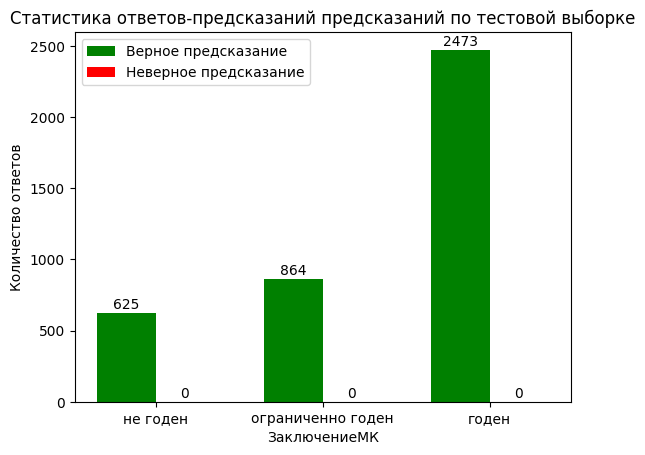

In [75]:
fig, ax = plt.subplots()

conclusion_lst = ['не годен', 'ограниченно годен', 'годен']
index = np.arange(len(conclusion_lst))
bar_width = 0.35

rects1 = ax.bar(index, arr_true, bar_width, color='g', label='Верное предсказание')
rects2 = ax.bar(index + bar_width, arr_false, bar_width, color='r', label='Неверное предсказание')

ax.set_xlabel('ЗаключениеМК')
ax.set_ylabel('Количество ответов')
ax.set_title('Статистика ответов-предсказаний предсказаний по тестовой выборке')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(conclusion_lst)

ax.legend()

for rect, value in zip(rects1, arr_true):
    height = rect.get_height()
    ax.annotate('{}'.format(value),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 1),
                textcoords="offset points",
                ha='center', va='bottom')

for rect, value in zip(rects2, arr_false):
    height = rect.get_height()
    ax.annotate('{}'.format(value),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 1),
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()

# Приказ №29Н Министерства здравоохранения Российской Федерации

https://normativ.kontur.ru/document?moduleId=1&documentId=416520

"МИНИСТЕРСТВО ЗДРАВООХРАНЕНИЯ РОССИЙСКОЙ ФЕДЕРАЦИИ
ПРИКАЗ
от 28 января 2021 г. N 29н
ОБ УТВЕРЖДЕНИИ ПОРЯДКА ПРОВЕДЕНИЯ ОБЯЗАТЕЛЬНЫХ ПРЕДВАРИТЕЛЬНЫХ И ПЕРИОДИЧЕСКИХ МЕДИЦИНСКИХ ОСМОТРОВ РАБОТНИКОВ, ПРЕДУСМОТРЕННЫХ ЧАСТЬЮ ЧЕТВЕРТОЙ СТАТЬИ 213 ТРУДОВОГО КОДЕКСА РОССИЙСКОЙ ФЕДЕРАЦИИ, ПЕРЕЧНЯ МЕДИЦИНСКИХ ПРОТИВОПОКАЗАНИЙ К ОСУЩЕСТВЛЕНИЮ РАБОТ С ВРЕДНЫМИ И (ИЛИ) ОПАСНЫМИ ПРОИЗВОДСТВЕННЫМИ ФАКТОРАМИ, А ТАКЖЕ РАБОТАМ, ПРИ ВЫПОЛНЕНИИ КОТОРЫХ ПРОВОДЯТСЯ ОБЯЗАТЕЛЬНЫЕ ПРЕДВАРИТЕЛЬНЫЕ И ПЕРИОДИЧЕСКИЕ МЕДИЦИНСКИЕ ОСМОТРЫ"

"Приложение N 2
к приказу Министерства здравоохранения
Российской Федерации
от 28 января 2021 г. N 29н

ПЕРЕЧЕНЬ МЕДИЦИНСКИХ ПРОТИВОПОКАЗАНИЙ К РАБОТАМ С ВРЕДНЫМИ И (ИЛИ) ОПАСНЫМИ ПРОИЗВОДСТВЕННЫМИ ФАКТОРАМИ, А ТАКЖЕ РАБОТАМ, ПРИ ВЫПОЛНЕНИИ КОТОРЫХ ПРОВОДЯТСЯ ОБЯЗАТЕЛЬНЫЕ ПРЕДВАРИТЕЛЬНЫЕ И ПЕРИОДИЧЕСКИЕ МЕДИЦИНСКИЕ ОСМОТРЫ"

**Использую Приложение №2 для дополнения вердикта мнением, почему человек не годен, или почему ограниченно годен.**

## Словарь-датафрейм болезней

Поля в таблице Приложения 2:

- Наименование болезней, степень нарушения функции организма,
- Код по МКБ-10,
- Вредные и (или) опасные производственные факторы,
- Виды работ

Дополнительно таблица Приложения 2 поделена на 17 классов болезней, по числу которых трансформировал оригинальный документ в текстовые-csv файлы с разделителем '|'.

In [76]:
# Создаем списки-классификаторы, которые потом будем использовать для пояснения решения
class29_lst = list()
class29_lst.append("Класс I. Некоторые инфекционные и паразитарные болезни")
class29_lst.append("Класс II. Новообразования")
class29_lst.append("Класс III. Болезни крови, кроветворных органов и отдельные нарушения, вовлекающие иммунный механизм")
class29_lst.append("Класс IV. Болезни эндокринной системы, расстройства питания, нарушения обмена веществ")
class29_lst.append("Класс V. Психические расстройства и расстройства поведения - по перечням и в порядке, утвержденным Правительством Российской Федерации")
class29_lst.append("Класс VI. Болезни нервной системы")
class29_lst.append("Класс VII. Болезни глаза и его придаточного аппарата")
class29_lst.append("Класс VIII. Болезни уха и сосцевидного отростка")
class29_lst.append("Класс IX. Болезни системы кровообращения")
class29_lst.append("Класс X. Болезни органов дыхания")
class29_lst.append("Класс XI. Болезни органов пищеварения")
class29_lst.append("Класс XII. Болезни кожи и подкожной клетчатки")
class29_lst.append("Класс XIII. Болезни костно-мышечной системы и соединительной ткани")
class29_lst.append("Класс XIV. Болезни мочеполовой системы")
class29_lst.append("Класс XV. Беременность, роды и послеродовой период")
class29_lst.append("Класс XVII. Врожденные аномалии, деформации и хромосомные нарушения")
class29_lst.append("Класс XIX. Травмы, отравления и некоторые другие последствия воздействий внешних причин")

# Наименование болезней
diseases29_lst = list()

# Создаю датафрейм из приложения 2 приказа №29Н
df29 = pd.DataFrame(columns=['Класс', 'Болезнь', 'МКБ10', 'ВредФакторы', 'ВидыРабот'])
df29['Класс'] = df29['Класс'].astype(int)
df29['Болезнь'] = df29['Болезнь'].astype(int)
df29['МКБ10'] = df29['МКБ10'].astype(str)
df29['ВредФакторы'] = df29['ВредФакторы'].astype(str)
df29['ВидыРабот'] = df29['ВидыРабот'].astype(str)

## Загрузка 17 текстовых файлов классов болезней

In [77]:
gdown.download('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=180prezoaEESrwOpYu7PgOHjytbZ4AceL', None, quiet=True)

'mkb10_disease.zip'

In [78]:
dir_name_29 = '/content/mkb10_disease'
fn_29 = dir_name_29 + '/prikazN29H_2-1.txt'
# print(f'fn_29: {fn_29}')

# разворачиваем архив, если он не развернут
if not os.path.exists(fn_29):
  !unzip -q mkb10_disease.zip

# смотрим список файлов
!ls '/content/mkb10_disease'

prikazN29H_2-10.txt  prikazN29H_2-17.txt  prikazN29H_2-5.txt
prikazN29H_2-11.txt  prikazN29H_2-19.txt  prikazN29H_2-6.txt
prikazN29H_2-12.txt  prikazN29H_2-1.txt   prikazN29H_2-7.txt
prikazN29H_2-13.txt  prikazN29H_2-2.txt   prikazN29H_2-8.txt
prikazN29H_2-14.txt  prikazN29H_2-3.txt   prikazN29H_2-9.txt
prikazN29H_2-15.txt  prikazN29H_2-4.txt


## Обработка 17 текстовых файлов классов болезней

In [79]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Расщепление строки `Код по МКБ-10` из приказа 29 по запятым и минусам
#~~~~~~~~~~~~~~~~~~~~~~~~
def mkb29_split(arg):
  '''
    Расщепление строки по запятым и минусам, удаление пробелов перед словом и после
    вход:
        arg: строка с запятыми или без запятых, с минусами или без
    выход:
        retVal: список строк
  '''
  # print(f'mkb29_split> arg: {arg}')

  # результирующий список
  retVal = list()
  # проверяем на nan
  if (arg == arg):
    # проверяем, что строка не пустая
    if arg:
      # удаляем пробелы в начале и конце слова
      str1 = arg.strip()
      # разбиваем строку по запятым и возвращаем список
      str_lst1 = str1.split(',')
      # print(f' str_lst1>: {len(str_lst1)}: {str_lst1}')
      for str_item1 in str_lst1:
        str_item2 = str_item1.strip()
        # проверяем, что строка не пустая
        if str_item2:
          # проверям строку на минус
          # print(f' str_item2: {str_item2}')
          if str_item2.find('-') >= 0:
            str_lst3 = str_item2.split('-')
            str_item31 = str_lst3[0].strip()
            str_item32 = str_lst3[1].strip()
            # print(f'  str_item31: `{str_item31}`')
            # print(f'  str_item32: `{str_item32}`')
            last_dot_index31 = str_item31.rfind('.')
            last_dot_index32 = str_item32.rfind('.')
            if last_dot_index31 >= 0 or last_dot_index32 >= 0:
              str41 = str_item31
              str42 = ""
              if last_dot_index31 >= 0:
                str41, str42 = str_item31[:last_dot_index31], str_item31[last_dot_index31+1:]
              #~
              str51 = str_item32
              str52 = ""
              if last_dot_index32 >= 0:
                str51, str52 = str_item32[:last_dot_index32], str_item32[last_dot_index32+1:]
              #~
              jnum42 = 0
              jnum52 = 0
              # проверяем, что строка не пустая
              if str42:
                jnum42 = int(str42)
              if str52:
                jnum52 = int(str52)
              #~
              # print(f'str41: `{str41}`, str42: `{str42}`, jnum42: `{jnum42}`')
              # print(f'str51: `{str51}`, str52: `{str52}`, jnum52: `{jnum52}`')
              for j in range(jnum42, jnum52+1):
                if (jnum42 == j):
                  retVal.append(str_item31)
                elif (jnum52+1 == j):
                  retVal.append(str_item32)
                else:
                  retVal.append(str41 + '.' + str(j))
            else:
              str_item40 = str_item31[:1]
              str_item41 = str_item31[1:]
              str_item42 = str_item32[1:]
              num41 = int(str_item41)
              num42 = int(str_item42)
              # print(f'  str_item40: `{str_item40}`, str_item41: `{str_item41}`, str_item42: `{str_item42}`')
              # print(f'  num41: `{num41}`, num42: `{num42}`')
              for i in range(num41, num42+1):
                if i < 10:
                  retVal.append(str_item40 + '0' + str(i))
                else:
                  retVal.append(str_item40 + str(i))
          else:
            # значение не содержит минус, то есть не диапазон
            retVal.append(str_item2)

  # print(f'    retVal: {retVal}')
  return retVal

In [80]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Расщепление строки `Вредные и (или) опасные производственные факторы` из приказа 29 по запятым и минусам
# Harmful Factors
#~~~~~~~~~~~~~~~~~~~~~~~~
def hf29_split(arg):
  '''
    Расщепление строки по запятым и минусам, удаление пробелов перед словом и после
    вход:
        arg: строка с запятыми или без запятых, с минусами или без
    выход:
        retVal: список строк
  '''
  # print(f'hf29_split> arg: {arg}')

  # результирующий список
  retVal = list()
  # проверяем на nan
  if (arg == arg):
    # проверяем, что строка не пустая
    if arg:
      # удаляем пробелы в начале и конце слова
      str1 = arg.strip()
      # разбиваем строку по запятым и возвращаем список
      str_lst1 = str1.split(',')
      for str_item1 in str_lst1:
        str_item2 = str_item1.strip()
        # проверяем, что строка не пустая
        if str_item2:
          # проверям строку на минус
          if str_item2.find('-') >= 0:
            str_lst3 = str_item2.split('-')
            str_item31 = str_lst3[0].strip()
            str_item32 = str_lst3[1].strip()
            if str_item31.find('.') >= 0:
              last_dot_index31 = str_item31.rfind('.')
              str41, str42 = str_item31[:last_dot_index31], str_item31[last_dot_index31+1:]
              # print(f'str41: {str41}')
              # print(f'str42: {str42}')
              last_dot_index32 = str_item32.rfind('.')
              str51, str52 = str_item32[:last_dot_index32], str_item32[last_dot_index32+1:]
              # print(f'str51: {str51}')
              # print(f'str52: {str52}')
              jnum42 = int(str42)
              jnum52 = int(str52)
              # print(f'jnum42: {jnum42} - jnum52: {jnum52}')
              for j in range(jnum42, jnum52+1):
                retVal.append(str41 + '.' + str(j))
              # print(f'retVal: {retVal}')
            else:
              num31 = int(str_item31)
              num32 = int(str_item32)
              for i in range(num31, num32+1):
                retVal.append(str(i))
          else:
            # значение не содержит минус, то есть не диапазон
            retVal.append(str_item2)

  return retVal

In [81]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Расщепление строки `Виды работ` из приказа 29 по запятым и минусам
# Types of work
#~~~~~~~~~~~~~~~~~~~~~~~~
def tow29_split(arg):
  '''
    Расщепление строки по запятым и минусам, удаление пробелов перед словом и после
    вход:
        arg: строка с запятыми или без запятых, с минусами или без
    выход:
        retVal: список строк
  '''
  # результирующий список
  retVal = list()
  # проверяем на nan
  if (arg == arg):
    # проверяем, что строка не пустая
    if arg:
      # удаляем пробелы в начале и конце слова
      str1 = arg.strip()
      # разбиваем строку по запятым и возвращаем список
      str_lst1 = str1.split(',')
      for str_item1 in str_lst1:
        str_item2 = str_item1.strip()
        # проверяем, что строка не пустая
        if str_item2:
          # проверям строку на минус
          if str_item2.find('-') >= 0:
            str_lst3 = str_item2.split('-')
            str_item31 = str_lst3[0].strip()
            str_item32 = str_lst3[1].strip()
            num31 = int(str_item31)
            num32 = int(str_item32)
            for i in range(num31, num32+1):
              retVal.append(str(i))
          else:
            # значение не содержит минус, то есть не диапазон
            retVal.append(str_item2)

  return retVal

In [82]:
def addClassToAccumulator29(file_name29, class29_inx, df_29):
  '''
    Чтение текстового файла и добавление его значений по спискам
    вход:
        file_name29: имя текстового файла
        class29_inx: индекс класса в списке class29_lst0
    выход:
        df_29: дополненный дата фрейм
  '''
  # print()
  # print('-'*50)
  # print(f'{file_name29}')
  # print(f'class29_inx: {class29_inx}')

  # чтение файла и создание списка строк
  # with open('/content/'+file_name29, 'r') as file29:
  with open(file_name29, 'r') as file29:
    lines29 = file29.readlines()

  # print(f'{len(lines29)}: {lines29}')

  for i in range(len(lines29)):
    # print(f'{i}->{len(lines29)}: {lines29[i]}')
    str1 = lines29[i].strip()
    # разбиваем строку по вертикальным линиям
    str_lst1 = str1.split('|')
    if 4 == len(str_lst1):
      # 0: `а) Активный туберкулез.... `
      # 1: `A15 - A19`
      # 2: `1 - 5`
      # 3: `6 - 27`
      #~~~0 ~ Наименование болезней
      diseases29_lst.append(str_lst1[0].strip())
      diseases29_inx = len(diseases29_lst) - 1
      # print(f'diseases29_inx: {diseases29_inx}, len(diseases29): {len(diseases29)}, {diseases29}')
      #~~~1 ~ МКБ-10
      mkb29_lst = mkb29_split(str_lst1[1].strip())
      if len(mkb29_lst) < 1:
        print(f'ОШИБКА: неверное значение МКБ: {file_name29}')
        continue
      # print(f'mkb29_lst: `{mkb29_lst}`')
      #~~~2 ~ Вредные факторы
      hf29_lst = hf29_split(str_lst1[2].strip())
      hf29_str = ""
      if len(hf29_lst) > 0:
        hf29_str = ','.join(hf29_lst)
      # print(f'hf29_lst: `{hf29_lst}`')
      # print(f'hf29_str: `{hf29_str}`')
      #~~~3 ~ Виды работ
      tow29_lst = tow29_split(str_lst1[3].strip())
      tow29_str = ""
      if len(tow29_lst) > 0:
        tow29_str = ','.join(tow29_lst)
      # print(f'tow29_lst: `{tow29_lst}`')
      # print(f'tow29_str: `{tow29_str}`')
      #~~~~~~~~~~~~~~~~~~~~~~~~
      #~~~~добавляю сформированне строки в датафрейм
      for j in range(len(mkb29_lst)):
        # print(f'{j}: {mkb29_lst[j]}')
        newrow_29 = {'Класс': class29_inx, 'Болезнь': diseases29_inx, 'МКБ10': mkb29_lst[j], 'ВредФакторы': hf29_str, 'ВидыРабот': tow29_str}
        df_29 = pd.concat([df_29, pd.DataFrame(newrow_29, index=[0])], ignore_index=True)
    else:
      print(f'ОШИБКА: неверное число данных в колонках: {file_name29}')

  return df_29

In [83]:
# Формирую-создаю датафрейм из приложения 2 приказа №29Н
print(f'число классов: {len(class29_lst)}')
for i in range(len(class29_lst)):
  print()
  print('-'*50)
  print(f'{i}: {class29_lst[i]}')
  j = i + 1
  if 15 == i:
    j = 17
  elif 16 == i:
    j = 19
  #~~~
  fn_29 = dir_name_29 + '/prikazN29H_2-' + str(j) + '.txt'
  print(f'fn_29: `{fn_29}`')
  #~~~
  df29 = addClassToAccumulator29(fn_29, i, df29);
  print(f'размеры датафрейма: df29: {df29.shape}')
  print(df29.tail(2))

число классов: 17

--------------------------------------------------
0: Класс I. Некоторые инфекционные и паразитарные болезни
fn_29: `/content/mkb10_disease/prikazN29H_2-1.txt`
размеры датафрейма: df29: (74, 5)
    Класс  Болезнь МКБ10 ВредФакторы       ВидыРабот
72      0        6   B82              23,24,25,26,27
73      0        6   B83              23,24,25,26,27

--------------------------------------------------
1: Класс II. Новообразования
fn_29: `/content/mkb10_disease/prikazN29H_2-2.txt`
размеры датафрейма: df29: (371, 5)
     Класс  Болезнь МКБ10 ВредФакторы ВидыРабот
369      1       14   D35           Р          
370      1       14   D36           Р          

--------------------------------------------------
2: Класс III. Болезни крови, кроветворных органов и отдельные нарушения, вовлекающие иммунный механизм
fn_29: `/content/mkb10_disease/prikazN29H_2-3.txt`
размеры датафрейма: df29: (571, 5)
     Класс  Болезнь МКБ10                                        ВредФакторы

## Пример работы с df29

In [84]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Пример получения информации по коду МКБ-10
#~~~~~~~~~~~~~~~~~~~~~~~~

mkb_10 = 'A16'
mkb_10 = 'T98'
mkb_10 = 'F98.5'
mkb_10 = 'H53.5'

# ДиагнозМКБ: Z00.0,M53.9,F10.1
# ДиагнозМКБ: N60.2,Z00.0,H52.2
# ДиагнозМКБ: Z00.0,K02.1

inxs29 = df29.index[df29['МКБ10'] == mkb_10].tolist()
print(f'{len(inxs29)}: {inxs29}')

for i in range(len(inxs29)):
  print()
  print('='*50)
  print(f'{i}->{len(inxs29)-1}')
  elems29 = df29.iloc[inxs29[i]].values
  print(f'{len(elems29)}: {elems29}')
  #~Класс
  print('-'*50)
  print('Класс:')
  ielem = int(elems29[0])
  print(f'  {ielem}: {class29_lst[ielem]}')
  #~Болезнь
  print('-'*50)
  print('Наименование болезней, степень нарушения функции организма:')
  ielem = int(elems29[1])
  print(f'  {ielem}: {diseases29_lst[ielem]}')
  #~МКБ10
  print('-'*50)
  print('Код по МКБ-10:')
  print(f'  {elems29[2]}')
  #~ВредФакторы
  print('-'*50)
  print('Вредные и (или) опасные производственные факторы:')
  print(f'  {elems29[3]}')
  #~ВидыРабот
  print('-'*50)
  print('Виды работ:')
  print(f'  {elems29[4]}')

1: [991]

0->0
5: [6 66 'H53.5' '' '19,20,21']
--------------------------------------------------
Класс:
  6: Класс VII. Болезни глаза и его придаточного аппарата
--------------------------------------------------
Наименование болезней, степень нарушения функции организма:
  66: Аномалии цветового зрения выраженной степени (дейтераномалия и/или протоаномалия типа A)
--------------------------------------------------
Код по МКБ-10:
  H53.5
--------------------------------------------------
Вредные и (или) опасные производственные факторы:
  
--------------------------------------------------
Виды работ :
  19,20,21


# Дополнение вердикта мнением, почему человек не годен, или почему ограниченно годен.

Выберем из тестовой выборки три возможных значения 0 - не годен, 1 - ограниченно годен, 2 - годен, и сформируем по ним дополнение вердикта данными из оригинального датасета и приказа №29Н.

## Функции формирования печати дополнений вердикта

In [85]:
# Фиксируем индексы трех строк из тестовой выборки (0 - не годен, 1 - ограниченно годен, 2 - годен)
inx0 = -1
inx1 = -1
inx2 = -1

col_inx = df1.columns.get_loc('кЗаключениеМК')
col_lst = df1.iloc[:, col_inx].tolist()
# print(f'кЗаключениеМК: {len(col_lst)}: {col_lst}')

for i in range(y_test.shape[0]):
  i_elem = col_lst[i]
  print(f'i: {i} -> {y_test.shape[0]}, i_elem: {i_elem}')
  if 0 == i_elem and -1 == inx0:
    inx0 = i
  elif 1 == i_elem and -1 == inx1:
    inx1 = i
  elif 2 == i_elem and -1 == inx2:
    inx2 = i

  if (not -1 == inx0) and (not -1 == inx1) and (not -1 == inx2):
    break

print('кЗаключениеМК:')
print(f'  0 - не годен: строка {inx0}')
print(f'  1 - ограниченно годен: строка {inx1}')
print(f'  2 - годен: строка {inx2}')

i: 0 -> 3962, i_elem: 1
i: 1 -> 3962, i_elem: 0
i: 2 -> 3962, i_elem: 2
кЗаключениеМК:
  0 - не годен: строка 1
  1 - ограниченно годен: строка 0
  2 - годен: строка 2


In [86]:
df1.head(5)

,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ДиагнозМКБ,ДиагнозОписание,кЗаключениеМК,ккЗаключениеМК,кВозраст,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккЦехПрофессия
0,a10991cd-c512-11ec-8100-0cc47aab8067,fcb5d710-c511-11ec-8100-0cc47aab8067,1981-09-09T00:00:00,Женский,Женский,2022-04-26T00:00:00,Периодический,Периодический,False,36b24009-f108-11ea-80e2-0cc47aab8067,...,"N60.2,Z00.0,H52.2",,1,"[0, 1, 0]",40,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,ade1be72-f084-11ed-812d-0cc47aab8067,3a43727c-63db-11e8-80ce-0cc47aab8067,1984-12-08T00:00:00,Мужской,Мужской,2023-05-12T00:00:00,Периодический,Периодический,False,226f6094-63db-11e8-80ce-0cc47aab8067,...,"Z00.0,M53.9,F10.1",[Z00.0] Общий медицинский осмотр|[M53.9] Дорсо...,0,"[1, 0, 0]",38,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,0,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,2591bd34-618f-11ed-8109-0cc47aab8067,fb2337bf-5a6a-11ed-8108-0cc47aab8067,1999-06-29T00:00:00,Женский,Женский,2022-11-11T00:00:00,Периодический,Периодический,False,b6882c37-6716-11e9-80ce-0cc47aab8067,...,"Z00.0,K02.1",[Z00.0] Общий медицинский осмотр|[K02.1] Карие...,2,"[0, 0, 1]",23,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,ad17fa7f-49fb-11ed-8107-0cc47aab8067,f53cf16d-83cd-11e6-82e0-d897ba0a5c60,1983-03-15T00:00:00,Женский,Женский,2022-10-12T00:00:00,Периодический,Периодический,False,e71ae138-fd17-11ea-80e2-0cc47aab8067,...,"Z00.0,K04.5",[Z00.0] Общий медицинский осмотр_x000D_|[K04.5...,2,"[0, 0, 1]",39,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,b6501a0c-2375-11ed-8104-0cc47aab8067,86591705-9ee4-11e8-80ce-0cc47aab8067,1976-08-13T00:00:00,Женский,Женский,2022-08-24T00:00:00,Периодический,Периодический,False,22f7abcc-90ca-11e8-80ce-0cc47aab8067,...,"Z00.0,K02.0",[Z00.0] Общий медицинский осмотр|[K02.0] Карие...,2,"[0, 0, 1]",46,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [210]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Получение значения ячейки по названию колонки и номеру строки
#~~~~~~~~~~~~~~~~~~~~~~~~
def get_df_cell_value(col_name, row_inx):
  '''
    Получение значения ячейки по названию колонки и номеру строки
    вход:
        col_name: название колонки в оригинальном датасете
        row_inx: индекс строки в оригинальном датасете
  '''
  col_inx = df1.columns.get_loc(col_name)
  retVal = df1.iloc[row_inx, col_inx]
  if not (retVal == retVal):
    retVal = ''
  return retVal

In [211]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Печать предсказания по номеру строки тестовой выборки
#~~~~~~~~~~~~~~~~~~~~~~~~
def print_prediction(row_inx):
  '''
    Печать предсказания по номеру строки тестовой выборки
    вход:
        row_inx: индекс строки в оригинальном датасете
  '''
  print('*'*100)
  print(f'Номер строки в тестовой выборке и оригинальном датасете: {row_inx}')
  print('='*50)
  str1 = get_df_cell_value('ЗаключениеМК', row_inx)
  print(f'ЗаключениеМК в оригинальном датасете: {str1}')
  num1 = get_df_cell_value('кЗаключениеМК', row_inx)
  if 0 == num1:
    str1 = 'не годен'
  elif 1 == num1:
    str1 = 'ограниченно годен'
  elif 2 == num1:
    str1 = 'годен'
  print(f'  кодовое значение: {num1} - {str1}')
  print('='*50)
  print('Предсказание нейронной сетью ЗаключенияМК:')
  print(f'  {pred1[row_inx]}')
  num1 = np.argmax(pred1[row_inx,:])
  if 0 == num1:
    str1 = 'не годен'
  elif 1 == num1:
    str1 = 'ограниченно годен'
  elif 2 == num1:
    str1 = 'годен'
  print(f'  {num1} - {str1}')

In [212]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Печать информации о клиенте из оригинального датасета
#~~~~~~~~~~~~~~~~~~~~~~~~
def print_client_info(row_inx):
  '''
    Печать информации о клиенте из оригинального датасета
    вход:
        row_inx: индекс строки в оригинальном датасете
  '''
  print()
  print('*'*100)
  print('Информация о клиенте из оригинального датасета:')
  print('-'*50)

  #~~~~~~~~~~~~~~~~~~~~~~~~
  df_origin_col = ['ДокументПрохождениеМедосмотра',
                   'Клиент',
                   'КлиентДатаРождения',
                   'КлиентПол',
                   'КлиентПолПредставление',
                   'ДатаЗавершенияМедосмотра',
                   'кВозраст',
                   'ТипМедосмотра',
                   'ТипМедосмотраПредставление',
                   'ПсихОсвидетельствование',
                   'Контрагент',
                   'Цех',
                   'Профессия',
                   'ЗаключениеМК',
                   'ЗаключениеМКПредставление',
                   'Заключение',
                   'ВредныеФакторы',
                   'ДиагнозМКБ',
                   'ДиагнозОписание'
                   ]
  #~~~
  for i in range(len(df_origin_col)):
    str1 = df_origin_col[i]
    if 'кВозраст' == str1:
      str1 = 'Возраст'
    str2 = get_df_cell_value(df_origin_col[i], row_inx)
    if (len(df_origin_col)-1 == i):
      print(f'{str1}:')
      str_lst2 = str2.split('|')
      for j in range(len(str_lst2)):
        print(f'  {str_lst2[j]}:')
    else:
      print(f'{str1}: {str2}')

In [213]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Печать дополнений вердикта по МКБ согласно приказа №29Н
#~~~~~~~~~~~~~~~~~~~~~~~~
def print_recommendation(row_inx):
  '''
    Печать дополнений вердикта по МКБ согласно приказа №29Н
    вход:
        row_inx: индекс строки в оригинальном датасете
  '''
  print()
  print('*'*100)
  print('Дополнения вердикта по МКБ согласно приказа №29Н:')
  #~~~
  str1 = get_df_cell_value('ДиагнозОписание', row_inx)
  str_lst1 = str1.split('|')
  for str_item1 in str_lst1:
    print('-'*50)
    str1 = str_item1.strip()
    print(str1)
    #~~~~~~~~~~~~~~~~~~~~~~~~
    mkb_start = str1.find("[") + 1
    mkb_end = str1.find("]")
    mkb_str1 = str1[mkb_start:mkb_end]
    if 'Z00.0' == mkb_str1:
      continue
    # mkb_end = mkb_end + 1
    # diagnosis_str1 = str1[mkb_end:]
    # print(f'  mkb_str1: {mkb_str1}')
    # print(f'  diagnosis_str1: {diagnosis_str1}')
    #~~~~~~~~~~~~~~~~~~~~~~~~
    inxs29 = df29.index[df29['МКБ10'] == mkb_str1].tolist()
    # print(f'{len(inxs29)}: {inxs29}')
    if 0 == len(inxs29):
      if "." in mkb_str1:
        mkb_point = mkb_str1.find(".")
        mkb_str2 = mkb_str1[:mkb_point]
        # print(f'mkb_str1: {mkb_str1}')
        # print(f'mkb_str2: {mkb_str2}')
        inxs29 = df29.index[df29['МКБ10'] == mkb_str2].tolist()

    #~~~~~~~~~~~~~~~~~~~~~~~~
    if 0 == len(inxs29):
      continue
    #~~~~~~~~~~~~~~~~~~~~~~~~
    print('Приказ №29Н:')
    for i in range(len(inxs29)):
      elems29 = df29.iloc[inxs29[i]].values
      print('    '+'-'*20)
      #~Класс
      print('    Класс:')
      if elems29[0]:
        ielem = int(elems29[0])
        print(f'      {ielem}: {class29_lst[ielem]}')
      #~Болезнь
      print('    Наименование болезней, степень нарушения функции организма:')
      if elems29[1]:
        ielem = int(elems29[1])
        print(f'      {ielem}: {diseases29_lst[ielem]}')
      #~МКБ10
      print('    Код по МКБ-10:')
      if elems29[2]:
        print(f'      {elems29[2]}')
      #~ВредФакторы
      print('    Вредные и (или) опасные производственные факторы:')
      if elems29[3]:
        print(f'      {elems29[3]}')
      #~ВидыРабот
      print('    Виды работ:')
      if elems29[4]:
        print(f'      {elems29[4]}')

## 0 - не годен

In [214]:
# 0 - не годен
print_prediction(inx0)
print_client_info(inx0)
print_recommendation(inx0)

****************************************************************************************************
Номер строки в тестовой выборке и оригинальном датасете: 1
ЗаключениеМК в оригинальном датасете: ВременноНегоден
  кодовое значение: 0 - не годен
Предсказание нейронной сетью ЗаключенияМК:
  [9.9998385e-01 1.6058899e-05 3.0031497e-08]
  0 - не годен

****************************************************************************************************
Информация о клиенте из оригинального датасета:
--------------------------------------------------
ДокументПрохождениеМедосмотра: ade1be72-f084-11ed-812d-0cc47aab8067
Клиент: 3a43727c-63db-11e8-80ce-0cc47aab8067
КлиентДатаРождения: 1984-12-08T00:00:00
КлиентПол: Мужской
КлиентПолПредставление: Мужской
ДатаЗавершенияМедосмотра: 2023-05-12T00:00:00
Возраст: 38
ТипМедосмотра: Периодический
ТипМедосмотраПредставление: Периодический
ПсихОсвидетельствование: False
Контрагент: 226f6094-63db-11e8-80ce-0cc47aab8067
Цех: 
Профессия: Водитель
Заключени

In [215]:
# 1 - ограниченно годен
print_prediction(inx1)
print_client_info(inx1)
print_recommendation(inx1)

****************************************************************************************************
Номер строки в тестовой выборке и оригинальном датасете: 0
ЗаключениеМК в оригинальном датасете: ГоденСКоррекциейЗрения
  кодовое значение: 1 - ограниченно годен
Предсказание нейронной сетью ЗаключенияМК:
  [5.4773668e-06 9.9999446e-01 4.3172585e-10]
  1 - ограниченно годен

****************************************************************************************************
Информация о клиенте из оригинального датасета:
--------------------------------------------------
ДокументПрохождениеМедосмотра: a10991cd-c512-11ec-8100-0cc47aab8067
Клиент: fcb5d710-c511-11ec-8100-0cc47aab8067
КлиентДатаРождения: 1981-09-09T00:00:00
КлиентПол: Женский
КлиентПолПредставление: Женский
ДатаЗавершенияМедосмотра: 2022-04-26T00:00:00
Возраст: 40
ТипМедосмотра: Периодический
ТипМедосмотраПредставление: Периодический
ПсихОсвидетельствование: False
Контрагент: 36b24009-f108-11ea-80e2-0cc47aab8067
Цех: 
Проф

In [216]:
# 2 - годен
print_prediction(inx2)
print_client_info(inx2)
print_recommendation(inx2)

****************************************************************************************************
Номер строки в тестовой выборке и оригинальном датасете: 2
ЗаключениеМК в оригинальном датасете: Годен
  кодовое значение: 2 - годен
Предсказание нейронной сетью ЗаключенияМК:
  [1.6335091e-05 7.4466166e-06 9.9997610e-01]
  2 - годен

****************************************************************************************************
Информация о клиенте из оригинального датасета:
--------------------------------------------------
ДокументПрохождениеМедосмотра: 2591bd34-618f-11ed-8109-0cc47aab8067
Клиент: fb2337bf-5a6a-11ed-8108-0cc47aab8067
КлиентДатаРождения: 1999-06-29T00:00:00
КлиентПол: Женский
КлиентПолПредставление: Женский
ДатаЗавершенияМедосмотра: 2022-11-11T00:00:00
Возраст: 23
ТипМедосмотра: Периодический
ТипМедосмотраПредставление: Периодический
ПсихОсвидетельствование: False
Контрагент: b6882c37-6716-11e9-80ce-0cc47aab8067
Цех: 
Профессия: Менеджер
ЗаключениеМК: Годен
Заклю